In [1]:
import pandas as pd
import numpy as np
import modules.analysis as analysis
import modules.utils as utils
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import sklearn
import matplotlib.pyplot as plt
from autorank import autorank,  _util

ERROR 1: PROJ: proj_create_from_database: Open of /global/scratch/users/maxgaber/envs/_eda/share/proj failed


In [13]:
from importlib import reload
reload(analysis)

<module 'modules.analysis' from '/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py'>

# TS decomposition analysis
## Create metric CSV

In [2]:
df = analysis.eval_metrics('2023020313988255', out_path='analysis/benchmark/', min_months=24)

## Plot benchmark charts

In [2]:
exp_ids = [2022102313544246, 2022102313544325, 2022110413591325, 2022110813610319, 
           2022110213583060, 2022110213583128, 2022110413591387, 2022110813610380,
           2022102513552709, 2022102513552801, 2022110313584614, 2022110813610397,
           2022103113574994, 2022103113574896, 2022110413591449, 2022110813610413,
          ]
var_sets = ['RS minimal', 'RS minimal', 'RS minimal', 'RS minimal', 
            'RS minimal +VI', 'RS minimal +VI', 'RS minimal +VI', 'RS minimal +VI',
            'RS', 'RS', 'RS', 'RS', 
            'RS meteo', 'RS meteo', 'RS meteo', 'RS meteo',
            ]
frameworks = ['Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon', 
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon', 
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon',
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon',
             ]

frames =[]
for idx, exp_id in enumerate(exp_ids):
    if exp_id is None:
        print(exp_id, 'skipped.')
        continue
        
    df = pd.read_csv('analysis/benchmark/' + str(exp_id) + '/metrics.csv')
    df['Explanatory variable set'] = var_sets[idx]
    df['Framework'] = frameworks[idx]
    frames.append(df)
    
df = pd.concat(frames)

In [3]:
# use this for 500m resolution only
df500 = pd.read_csv('analysis/benchmark/2023020313988255/metrics.csv')

In [15]:
# calc z-score for outlier values
mean = df.loc[(df.Framework == 'H2O AutoML') & (df['Explanatory variable set'] == 'RS'), 'r2_overall'].mean()
std = df.loc[(df.Framework == 'H2O AutoML') & (df['Explanatory variable set'] == 'RS'), 'r2_overall'].std()
(df.loc[(df.Framework == 'H2O AutoML') & (df['Explanatory variable set'] == 'RS'), 'r2_overall'] - mean)/std

0     0.177666
1     0.392302
2     0.386877
3    -0.024734
4     0.316983
5     0.081310
6    -0.135370
7    -5.061730
8     0.370234
9     0.400755
10    0.024123
11    0.271240
12    0.176435
13    0.338549
14    0.282687
15    0.384719
16    0.151239
17   -0.755565
18    0.452542
19   -0.501568
20    0.141709
21    0.478297
22    0.456056
23    0.202369
24    0.300702
25    0.455483
26    0.286204
27   -0.372246
28   -0.002770
29    0.325501
Name: r2_overall, dtype: float64

In [3]:
# rm H2O outlier
df = df[~(df.exp_id == '2022102513552801_1')]

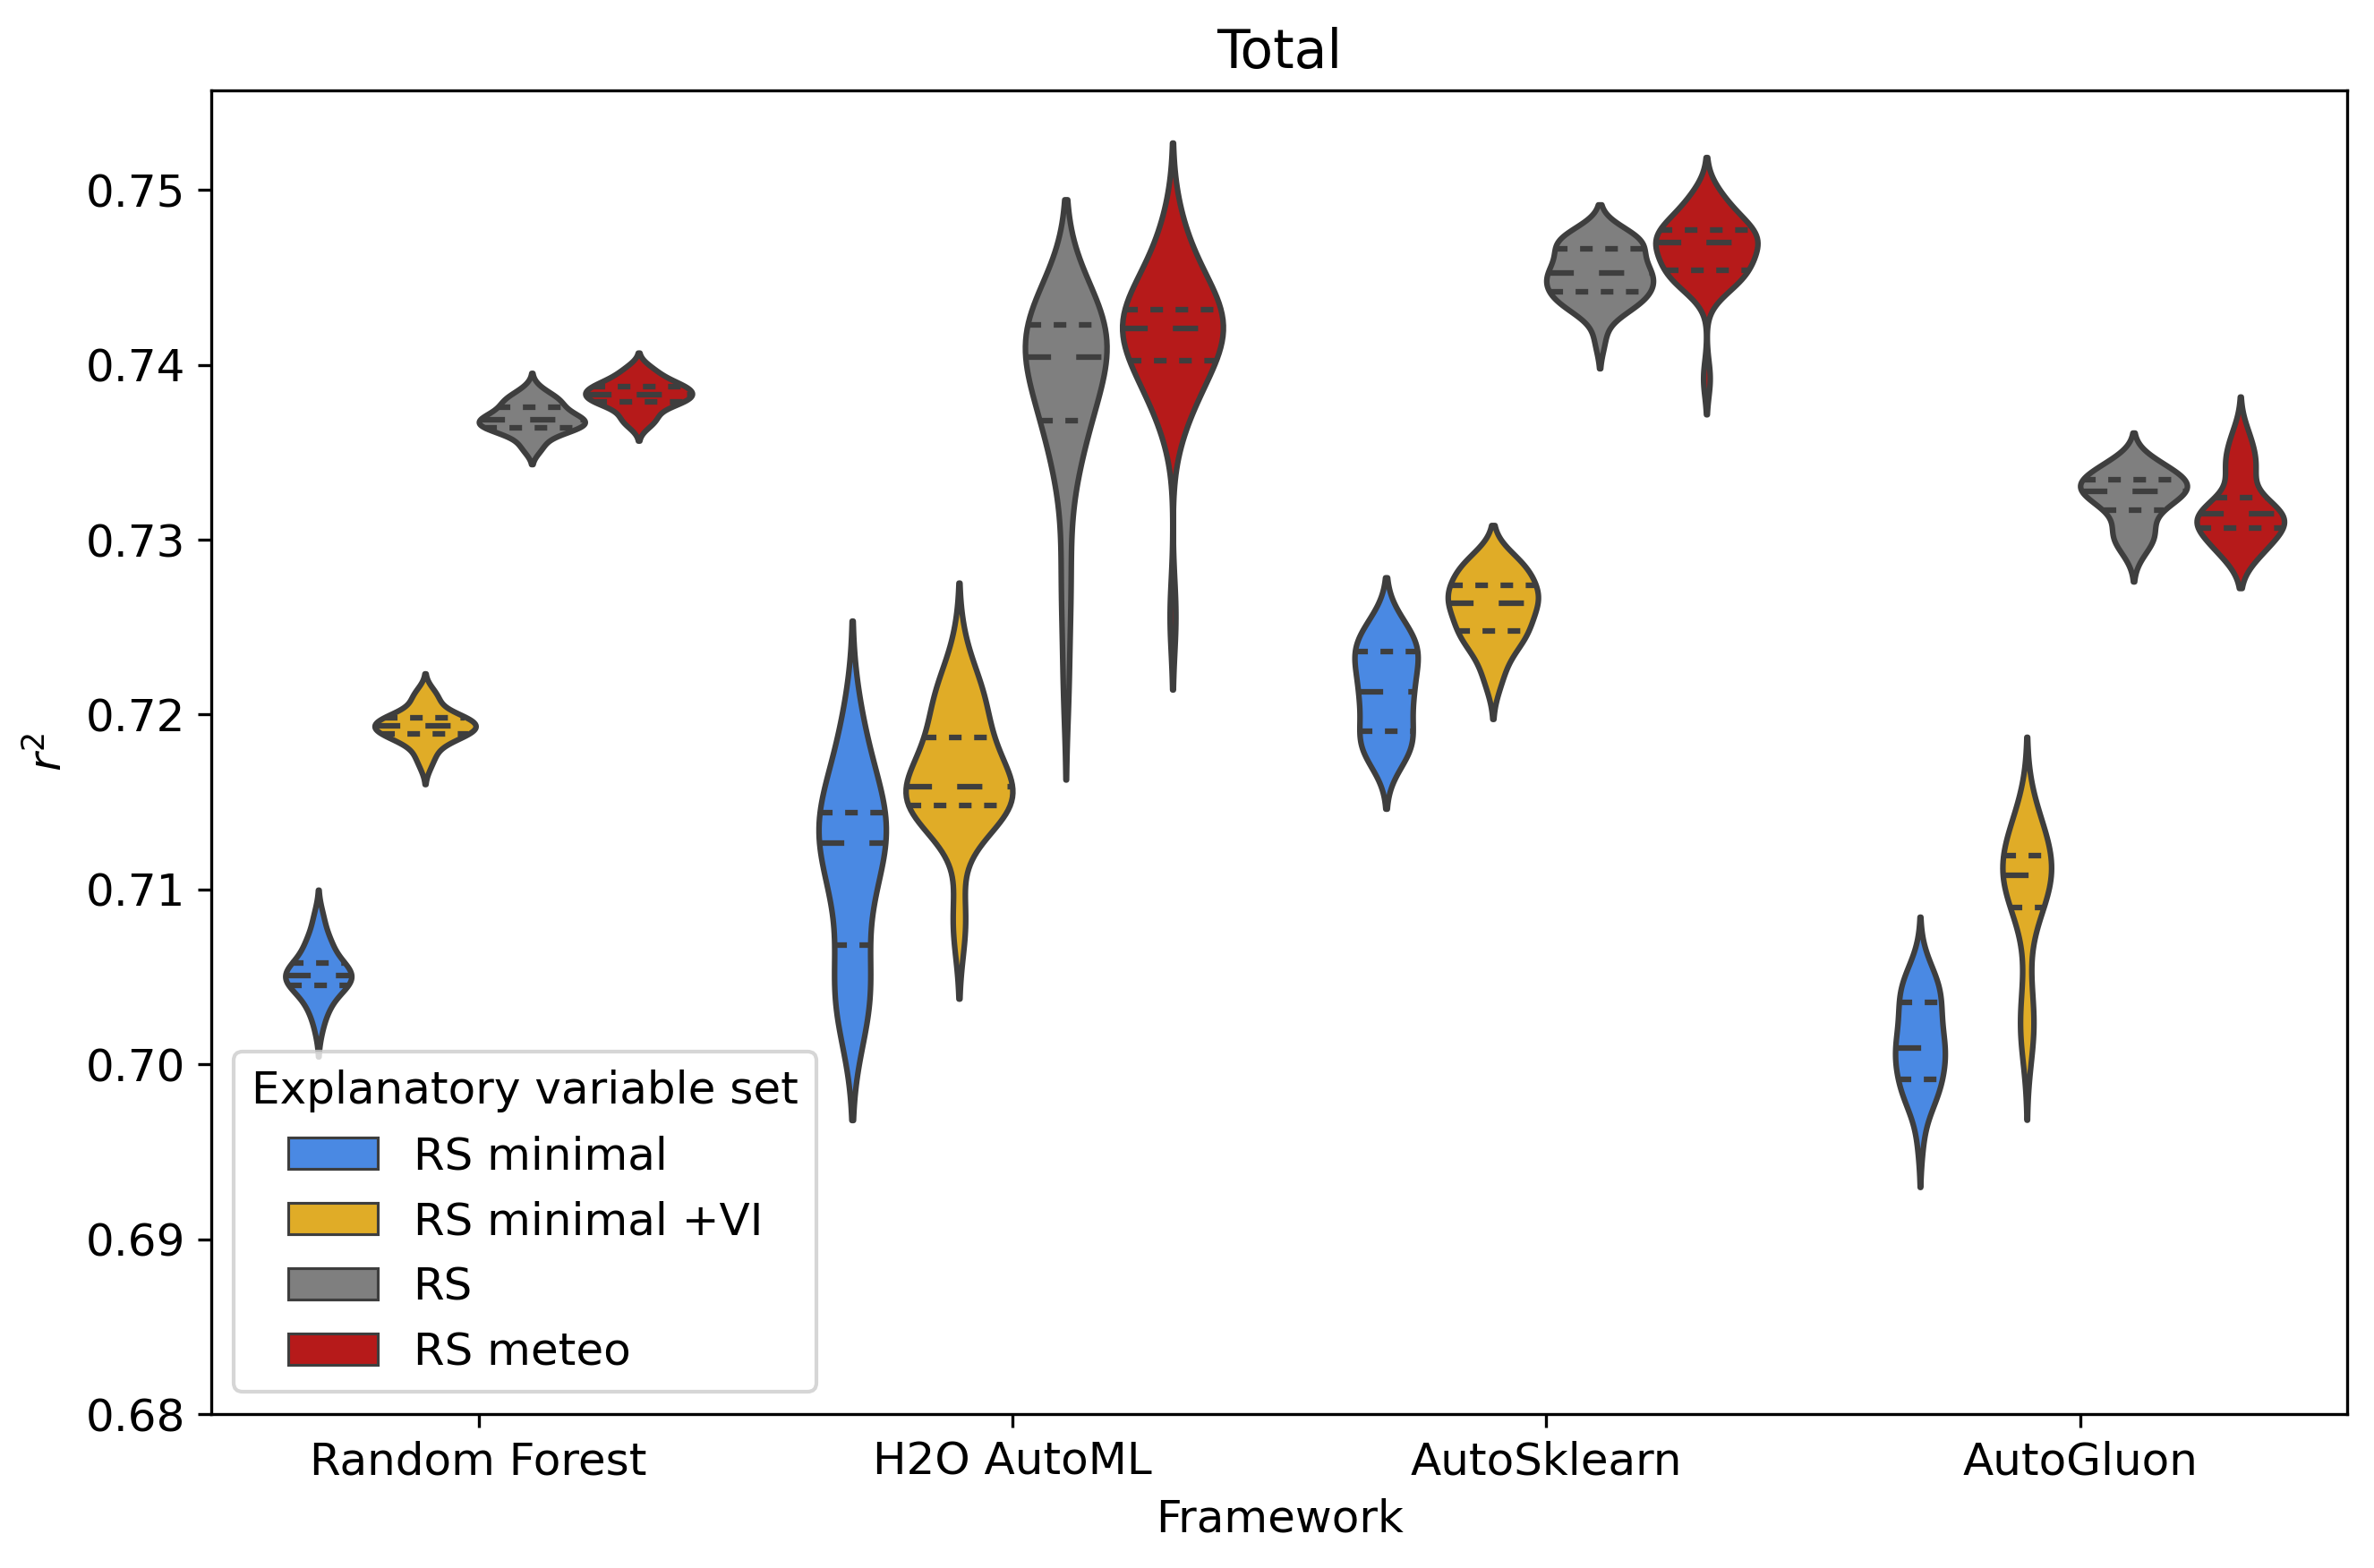

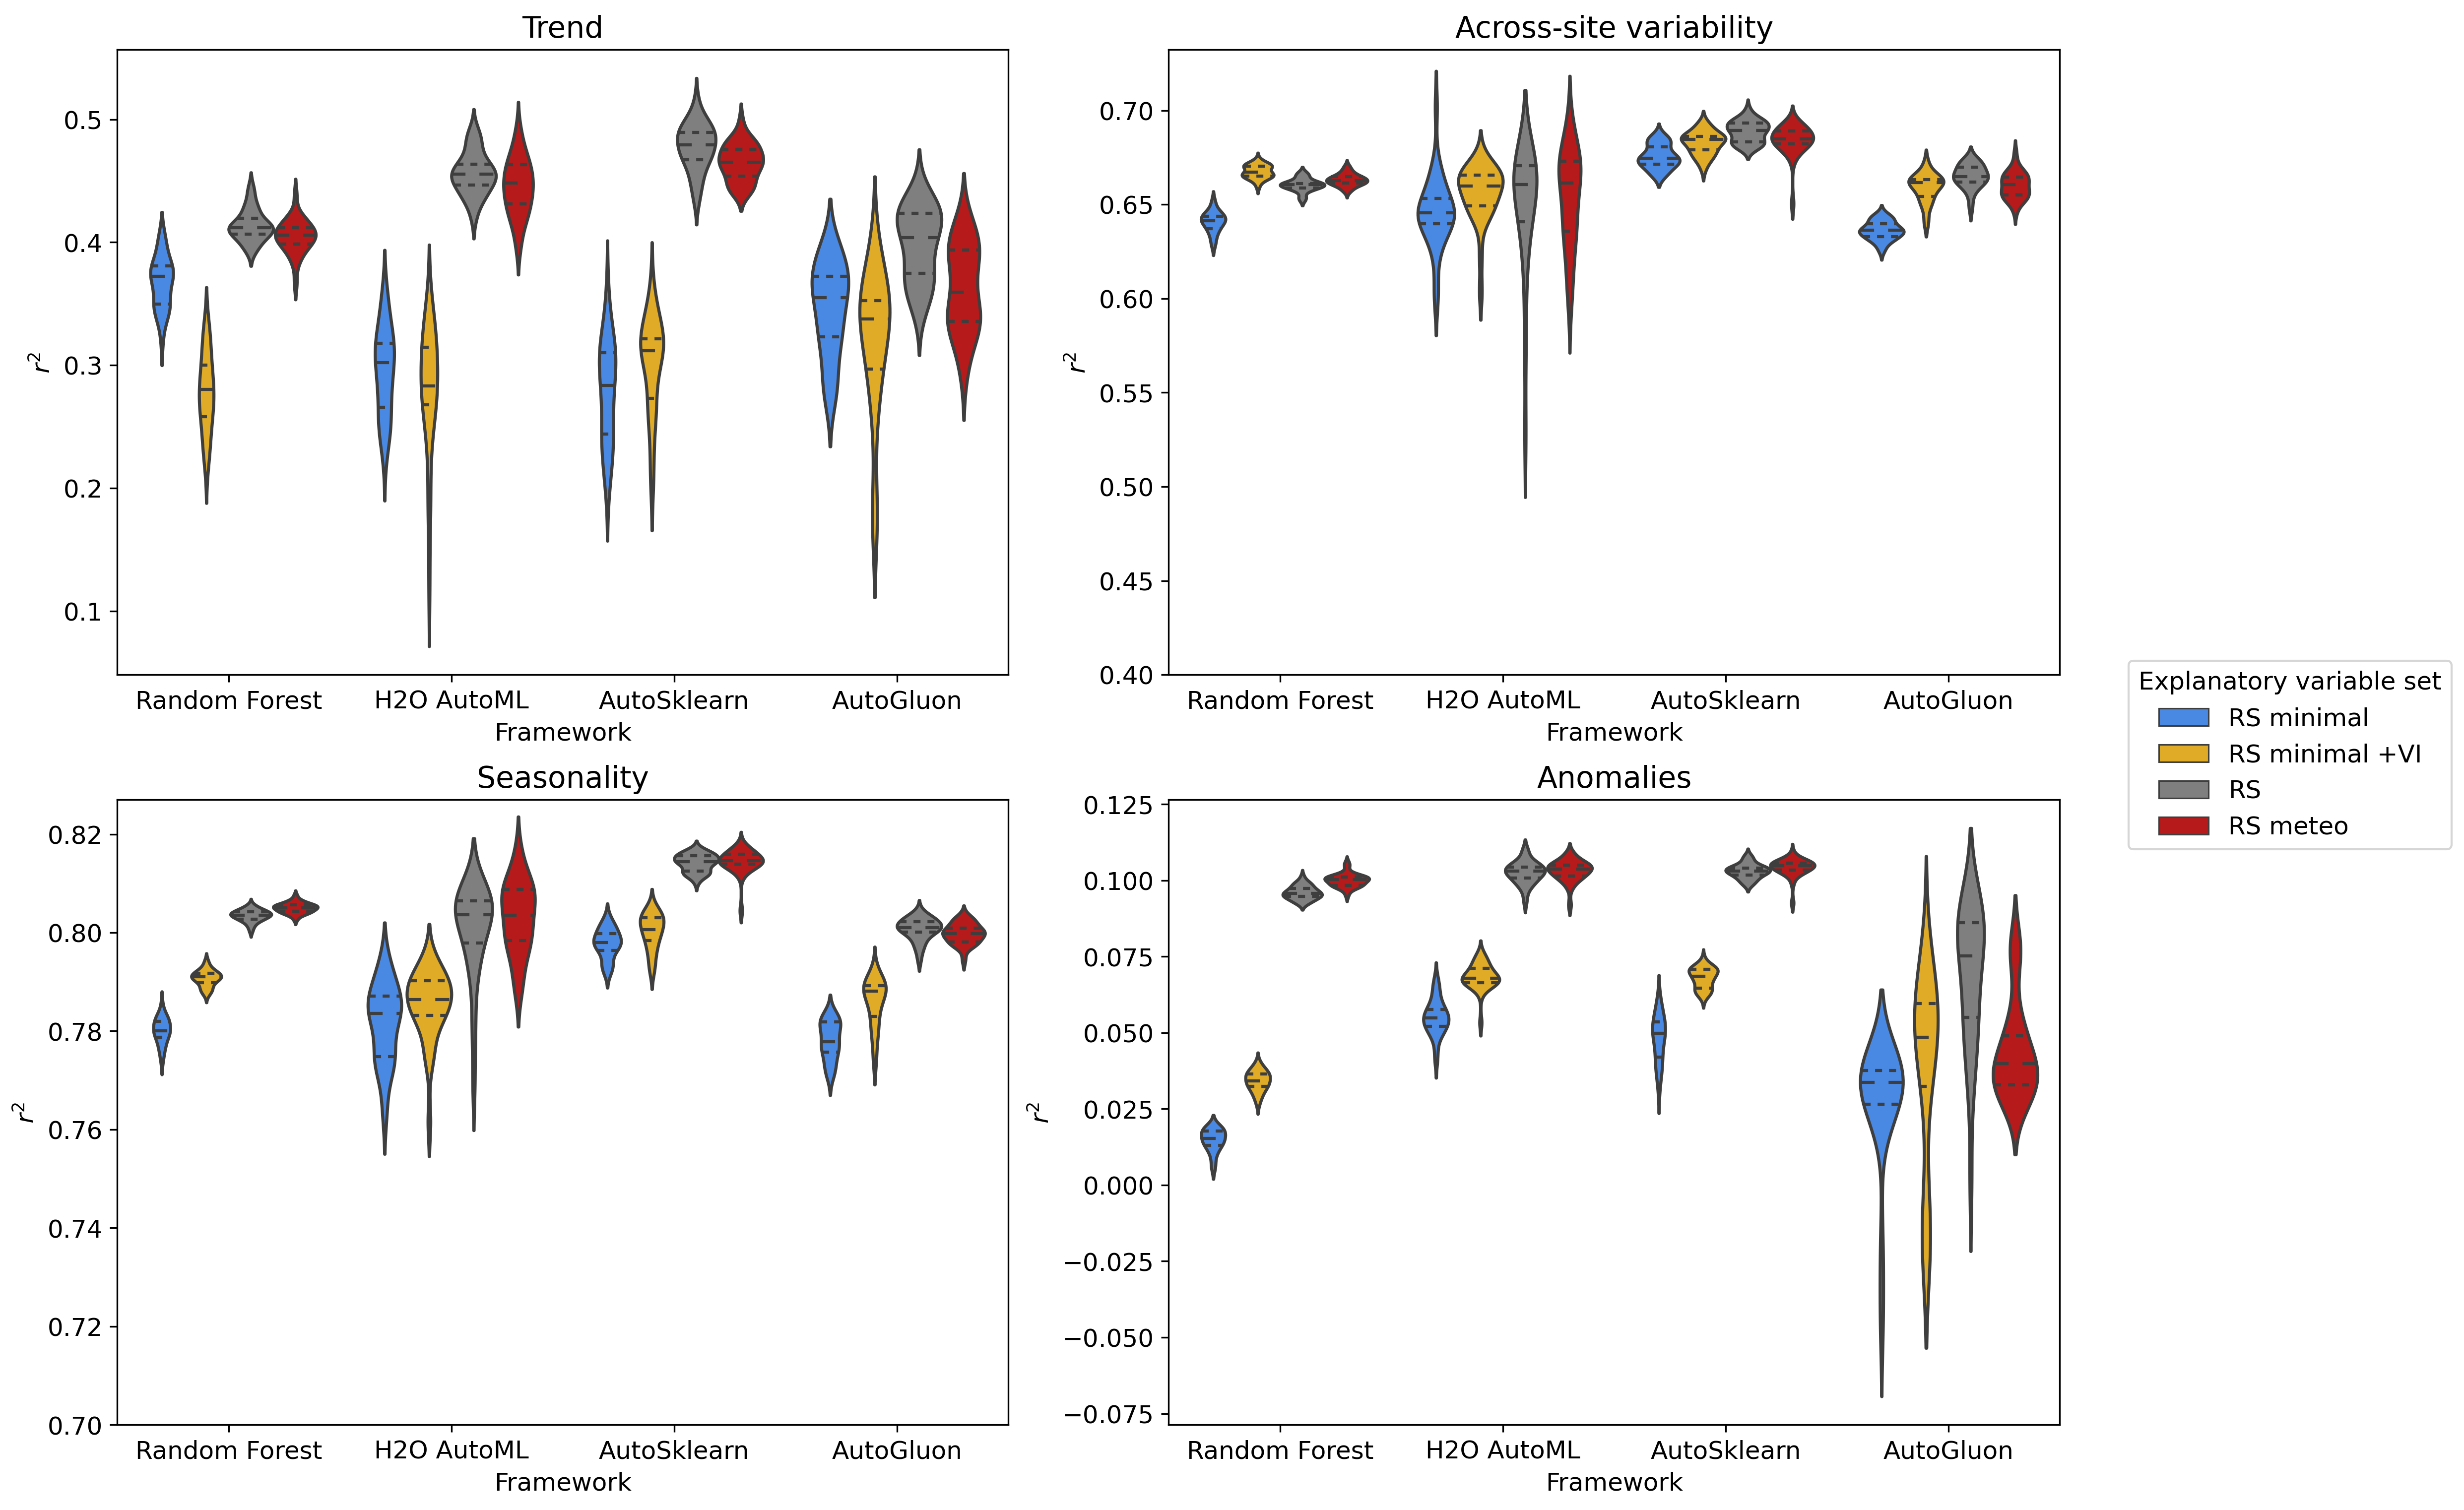

In [14]:
analysis.plt_model_comparison(df, 'analysis/benchmark/', 'Explanatory variable set', 'Framework', 'r2_overall', ylims=[(0.68, None), None, (0.4, None), (0.7, None), None])

## Testing

In [10]:
df.columns = ['exp_id', 'r2 overall', 'r2 trend', 'r2 anomalies', 'r2 across site variability', 'r2 mean seasonal cycle', 'RMSE overall', 'RMSE trend', 'RMSE anomalies', 'RMSE across site variability', 'RMSE mean seasonal cycle', 'Explanatory variable set', 'Framework']

In [18]:
df.groupby(['Framework', 'Explanatory variable set']).mean()

/tmp/ipykernel_198/511759837.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Framework', 'Explanatory variable set']).mean()


r2 overall  r2 trend  r2 anomalies  \
Framework     Explanatory variable set                                       
AutoGluon     RS                          0.732416  0.398281      0.068313   
              RS meteo                    0.731773  0.362325      0.043870   
              RS minimal                  0.701308  0.345597      0.026747   
              RS minimal +VI              0.709655  0.319889      0.037552   
AutoSklearn   RS                          0.745202  0.477413      0.103077   
              RS meteo                    0.746581  0.464917      0.104210   
              RS minimal                  0.721410  0.278891      0.048244   
              RS minimal +VI              0.726082  0.301064      0.068003   
H2O AutoML    RS                          0.738512  0.455900      0.102604   
              RS meteo                    0.741576  0.444822      0.103198   
              RS minimal                  0.711214  0.295208      0.055044   
              RS minimal +VI              0.716639  0.280111      0.068353   
Random Forest RS                          0.736942  0.413648      0.096008   
              RS meteo                    0.738279  0.404736      0.100064   
              RS minimal                  0.705215  0.367369      0.014700   
              RS minimal +VI              0.719338  0.277841      0.034191   

                                        r2 across site variability  \
Framework     Explanatory variable set                               
AutoGluon     RS                                          0.664953   
              RS meteo                                    0.660072   
              RS minimal                                  0.636158   
              RS minimal +VI                              0.658935   
AutoSklearn   RS                                          0.688638   
              RS meteo                                    0.684148   
              RS minimal                                  0.675457   
              RS minimal +VI                              0.682727   
H2O AutoML    RS                                          0.648787   
              RS meteo                                    0.653530   
              RS minimal                                  0.645589   
              RS minimal +VI                              0.655868   
Random Forest RS                                          0.660388   
              RS meteo                                    0.663041   
              RS minimal                                  0.640792   
              RS minimal +VI                              0.667435   

                                        r2 mean seasonal cycle  RMSE overall  \
Framework     Explanatory variable set                                         
AutoGluon     RS                                      0.800695      1.984148   
              RS meteo                                0.799796      1.986526   
              RS minimal                              0.778099      2.096417   
              RS minimal +VI                          0.785791      2.066893   
AutoSklearn   RS                                      0.814157      1.936164   
              RS meteo                                0.814452      1.930908   
              RS minimal                              0.797806      2.024645   
              RS minimal +VI                          0.800177      2.007604   
H2O AutoML    RS                                      0.800361      1.961328   
              RS meteo                                0.803163      1.949839   
              RS minimal                              0.781689      2.061302   
              RS minimal +VI                          0.785395      2.041886   
Random Forest RS                                      0.803474      1.987617   
              RS meteo                                0.805020      1.982558   
              RS minimal                              0.780026      2.080443   
              

In [19]:
df.groupby(['Framework', 'Explanatory variable set']).agg(lambda x: x.std(ddof=1) / np.sqrt(x.count()))

/tmp/ipykernel_198/1796959565.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  df.groupby(['Framework', 'Explanatory variable set']).agg(lambda x: x.std(ddof=1) / np.sqrt(x.count()))


r2 overall  r2 trend  r2 anomalies  \
Framework     Explanatory variable set                                       
AutoGluon     RS                          0.000286  0.005726      0.004424   
              RS meteo                    0.000369  0.006738      0.002992   
              RS minimal                  0.000471  0.006816      0.003935   
              RS minimal +VI              0.000714  0.010726      0.005814   
AutoSklearn   RS                          0.000287  0.003452      0.000430   
              RS meteo                    0.000370  0.002704      0.000531   
              RS minimal                  0.000461  0.007558      0.001397   
              RS minimal +VI              0.000353  0.007031      0.000610   
H2O AutoML    RS                          0.000998  0.003183      0.000670   
              RS meteo                    0.000755  0.004180      0.000617   
              RS minimal                  0.000944  0.006494      0.001074   
              RS minimal +VI              0.000655  0.009297      0.000778   
Random Forest RS                          0.000156  0.002284      0.000396   
              RS meteo                    0.000154  0.002451      0.000389   
              RS minimal                  0.000269  0.003812      0.000674   
              RS minimal +VI              0.000178  0.005699      0.000604   

                                        r2 across site variability  \
Framework     Explanatory variable set                               
AutoGluon     RS                                          0.001212   
              RS meteo                                    0.001296   
              RS minimal                                  0.000891   
              RS minimal +VI                              0.001376   
AutoSklearn   RS                                          0.001019   
              RS meteo                                    0.001468   
              RS minimal                                  0.001139   
              RS minimal +VI                              0.001108   
H2O AutoML    RS                                          0.006208   
              RS meteo                                    0.004604   
              RS minimal                                  0.003447   
              RS minimal +VI                              0.002693   
Random Forest RS                                          0.000621   
              RS meteo                                    0.000576   
              RS minimal                                  0.001010   
              RS minimal +VI                              0.000636   

                                        r2 mean seasonal cycle  RMSE overall  \
Framework     Explanatory variable set                                         
AutoGluon     RS                                      0.000432      0.001061   
              RS meteo                                0.000386      0.001369   
              RS minimal                              0.000705      0.001653   
              RS minimal +VI                          0.000891      0.002531   
AutoSklearn   RS                                      0.000320      0.001089   
              RS meteo                                0.000437      0.001407   
              RS minimal                              0.000549      0.001676   
              RS minimal +VI                          0.000660      0.001294   
H2O AutoML    RS                                      0.001760      0.003714   
              RS meteo                                0.001325      0.002830   
              RS minimal                              0.001441      0.003366   
              RS minimal +VI                          0.001259      0.002359   
Random Forest RS                                      0.000216      0.000589   
              RS meteo                                0.000186      0.000582   
              RS minimal                              0.000484      0.000950   
              

### Friedman and Nemeyi Test

In [16]:
def cd_plot(result, ax=None):
    # necessary since the autorank package messes up the cd plot
    rankdf, treatments, groups = _util.get_sorted_rank_groups(result, True)
    cd = result.cd
    meanrank = rankdf.values
    
    plot = False
    if ax is None:
        _, ax = plt.subplots(figsize=(5,1.8))
        plt.subplots_adjust(left=0.2, right=0.8)
        plot = True

    limits = (len(treatments), 1)
    split = len(treatments) // 2
    cd_ypos = 0.4
    label_yoffset = -0.4
    label_yincr = -0.4
    bar_yoffset = -0.1
    bar_yincr = -0.1
    label_ymax = label_yoffset + (split -1) * label_yincr + len(groups) * bar_yincr + bar_yoffset

    # set up plot
    ax.set_xlim(limits)
    ax.set_ylim(-1, 0.6)
    ax.spines['top'].set_position('zero')
    #ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_visible(False)
    for pos in ["bottom", "left", "right"]: 
        ax.spines[pos].set_visible(False)

    # CD bar
    ax.plot([limits[0],limits[0]-cd], [cd_ypos,cd_ypos], color="k")
    ax.plot([limits[0],limits[0]], [cd_ypos-0.03,cd_ypos+0.03], color="k")
    ax.plot([limits[0]-cd,limits[0]-cd], [cd_ypos-0.03,cd_ypos+0.03], color="k") 
    ax.text(limits[0]-cd/2., cd_ypos, "CD", ha="center", va="bottom") 

    # annotations
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=90")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, va="center")

    idx_sorted = np.argsort(meanrank)

    # left side
    label_y = label_yoffset
    for ii in range(0, split):
        idx = idx_sorted[ii]
        ax.annotate(treatments[idx], xy=(meanrank[idx], 0), xytext=(limits[1]-0.1, label_y), ha='left',**kw)
        label_y += label_yincr

    # right side
    label_y = label_ymax
    for ii in range(split, len(treatments)):
        idx = idx_sorted[ii]
        ax.annotate(treatments[idx], xy=(meanrank[idx], 0), xytext=(limits[0] + 0.1, label_y), ha='right',**kw)
        label_y -= label_yincr

    vert_pos = bar_yoffset
    for group in groups:
        ax.hlines(y=vert_pos, xmin=meanrank[group[1]]+0.03, xmax=meanrank[group[0]]-0.03, linewidth=3, color='black')
        vert_pos += bar_yincr

    if plot:
        plt.show()
    return ax

------ r2 overall
models:  ['AutoGluon' 'Random Forest' 'H2O AutoML' 'AutoSklearn']
friedman p-value= 5.4238275308159005e-12
shapiro p-value= [1.0, 0.8882977366447449, 1.0, 0.3671954274177551]
cd= 0.856338536493276
------ r2 trend
models:  ['AutoGluon' 'Random Forest' 'H2O AutoML' 'AutoSklearn']
friedman p-value= 1.5112452216358951e-12
shapiro p-value= [1.0, 0.13330833613872528, 1.0, 0.7136847972869873]
cd= 0.856338536493276
------ r2 mean seasonal cycle
models:  ['AutoGluon' 'H2O AutoML' 'Random Forest' 'AutoSklearn']
friedman p-value= 1.8564620659255853e-10
shapiro p-value= [1.0, 0.5790812373161316, 0.17802049219608307, 1.0]
cd= 0.856338536493276
------ r2 across site variability
models:  ['Random Forest' 'H2O AutoML' 'AutoGluon' 'AutoSklearn']
friedman p-value= 8.812400599253848e-11
shapiro p-value= [1.0, 0.0367179811000824, 0.22181940078735352, 1.0]
cd= 0.856338536493276
------ r2 anomalies
models:  ['AutoGluon' 'Random Forest' 'AutoSklearn' 'H2O AutoML']
friedman p-value= 1.481813

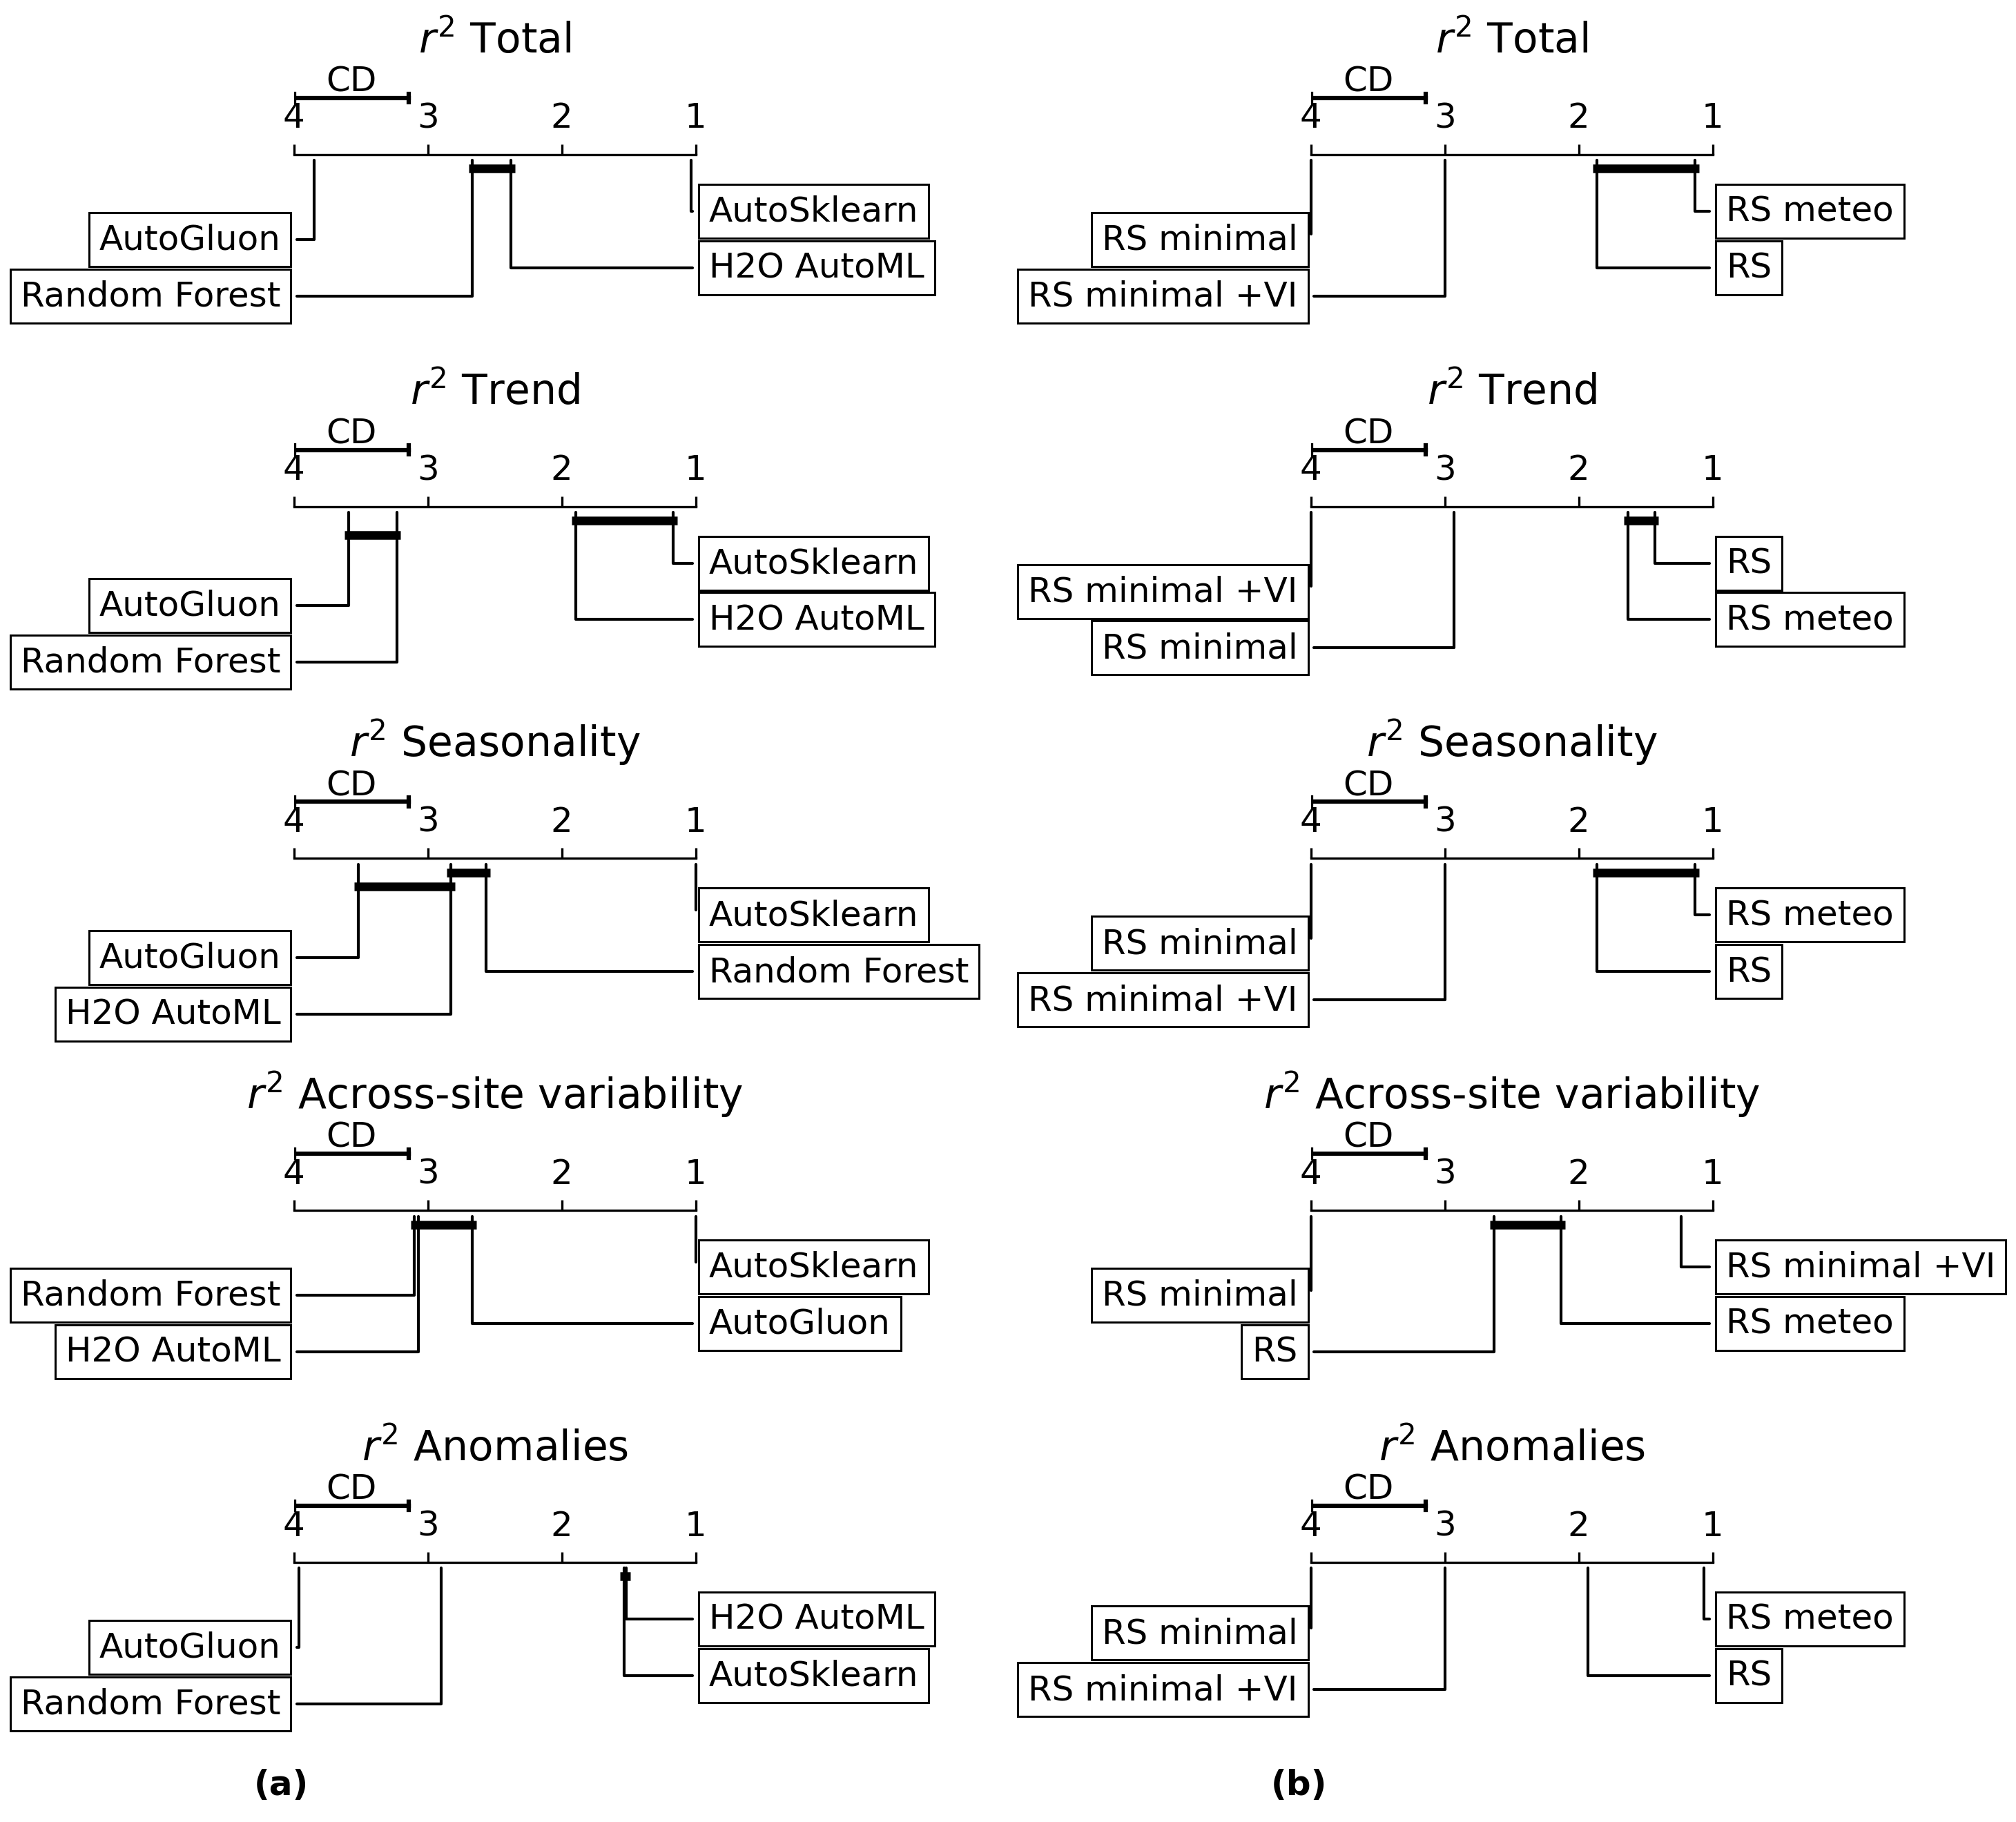

In [17]:
# evaluates differences in framework ranks
median_r2_fw = df.set_index(['Framework', 'Explanatory variable set'], append=True)#.groupby(['Framework', 'Explanatory variable set']).median()

# drop experiments not executed for all models
median_r2_fw = median_r2_fw[median_r2_fw.index.get_level_values(level=2).isin(['RS'])] #['RS minimal', 'RS minimal +VI', 'RS', 'RS meteo']

# evaluates differences in predictor variable ranks
median_r2_var = df.set_index(['Framework', 'Explanatory variable set'], append=True)#.groupby(['Framework', 'Explanatory variable set']).median()

# drop experiments not executed for all models
median_r2_var = median_r2_var.loc[(slice(None), 'Random Forest', slice(None)),:]
median_r2_var = median_r2_var[median_r2_var.index.get_level_values(level=2).isin(['RS minimal', 'RS minimal +VI', 'RS', 'RS meteo'])]

fig, axs = plt.subplots(5, 2, figsize=(10, 9))
cols = ['r2 overall', 'r2 trend', 'r2 mean seasonal cycle', 'r2 across site variability', 'r2 anomalies']
col_names = ['$r^2$ Total', '$r^2$ Trend', '$r^2$ Seasonality', '$r^2$ Across-site variability', '$r^2$ Anomalies']
fig_names = ['(a)', '(b)']
ds = [median_r2_fw, median_r2_var]

for hh in range(0, 2):
    for ii in range(0, 5):
        median_r2_select = ds[hh][cols[ii]].unstack(level=hh+1)
        result = autorank(median_r2_select, alpha=0.05, verbose=False)
        print('------', cols[ii])
        print('models: ', result.rankdf.index.values)
        print('friedman p-value=', result.pvalue)
        print('shapiro p-value=', result.pvals_shapiro)
        print('cd=', result.cd)
        cd_plot(result, ax=axs[ii, hh])
        axs[ii, hh].set_title(col_names[ii])
    
    axs[-1, hh].text(-0.1, -0.4, fig_names[hh], transform=axs[-1, hh].transAxes, size=12, weight='bold')
        
plt.tight_layout()
plt.savefig('analysis/benchmark/benchmark_friedman_comb.pdf')

### Wilcoxon Test

In [11]:
baseline_framework = 'AutoSklearn'
comparison_framework = 'AutoSklearn'
ts_feature = 'r2_anomalies'
baseline_variable = 'RS'
comparison_variable = 'RS meteo'

baseline = df.loc[(df['Framework'] == baseline_framework) & (df['Explanatory variable set'] == baseline_variable), ts_feature]
comparison = df.loc[(df['Framework'] == comparison_framework) & (df['Explanatory variable set'] == comparison_variable), ts_feature]

# perform a shapiro-wilk test for normality
# H0: r2 drawn from normal distribution
# H1: Not drawn from normal distribution
# significance: 5%

test_stat, p_value = stats.shapiro(comparison)
print('shapiro:', test_stat, p_value)


# perform one-sided z-test
# H0: Mean r2 not better than baseline RF
# H1: Mean r2 better than baseline
# significance: 5%

z_value, p_value = ztest(baseline, comparison, alternative='smaller')
print('z-test:', z_value, p_value)

# perform one-sided wilcox-signed rank test
# H0: The distribution of differences in r2 is symmetric to zero
# H1: The distribution is stochastically less than a distribution symmetric to zero
# significance: 5%

wilcox_value, p_value = stats.wilcoxon(baseline, comparison, alternative='less')
print('wilcoxon:', wilcox_value, p_value)

shapiro: 0.8055263757705688 8.280678594019264e-05
z-test: -1.658183918124973 0.04864017487546199
wilcoxon: 128.0 0.01549240481108427


# Land cover analysis
## Create LC metrics

In [33]:
sites = pd.read_csv('data/ec/sites_meta_v1.csv', index_col=0)
lc_metrics = analysis.eval_lc('2022110313584614', 'experiments/', sites, out_path='analysis/benchmark/', min_months=24)

## Plot LC analysis

In [18]:
lc_metrics = pd.read_csv('analysis/benchmark/2022110313584614/metrics_lc.csv', index_col='SITE_ID')
lc_metrics = lc_metrics.rename(columns={'IGBP': 'Land Cover'}).reset_index()

In [43]:
lc_metrics.groupby('Land Cover').median()

/tmp/ipykernel_180/281593598.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lc_metrics.groupby('Land Cover').median()


,r2_overall,r2_msc,r2_anomalies
Land Cover,,,
CRO,0.510335,0.832995,0.071058
DBF,0.869844,0.889265,0.287838
EBF,-0.380070,-0.406061,0.030975
ENF,0.793653,0.871212,0.077759
GRA,0.626121,0.700164,0.264273
MF,0.839219,0.874533,0.082496
SAV,0.620395,0.677627,0.362109
SH,0.327845,0.401234,0.217041
WET,0.480434,0.651493,0.002835


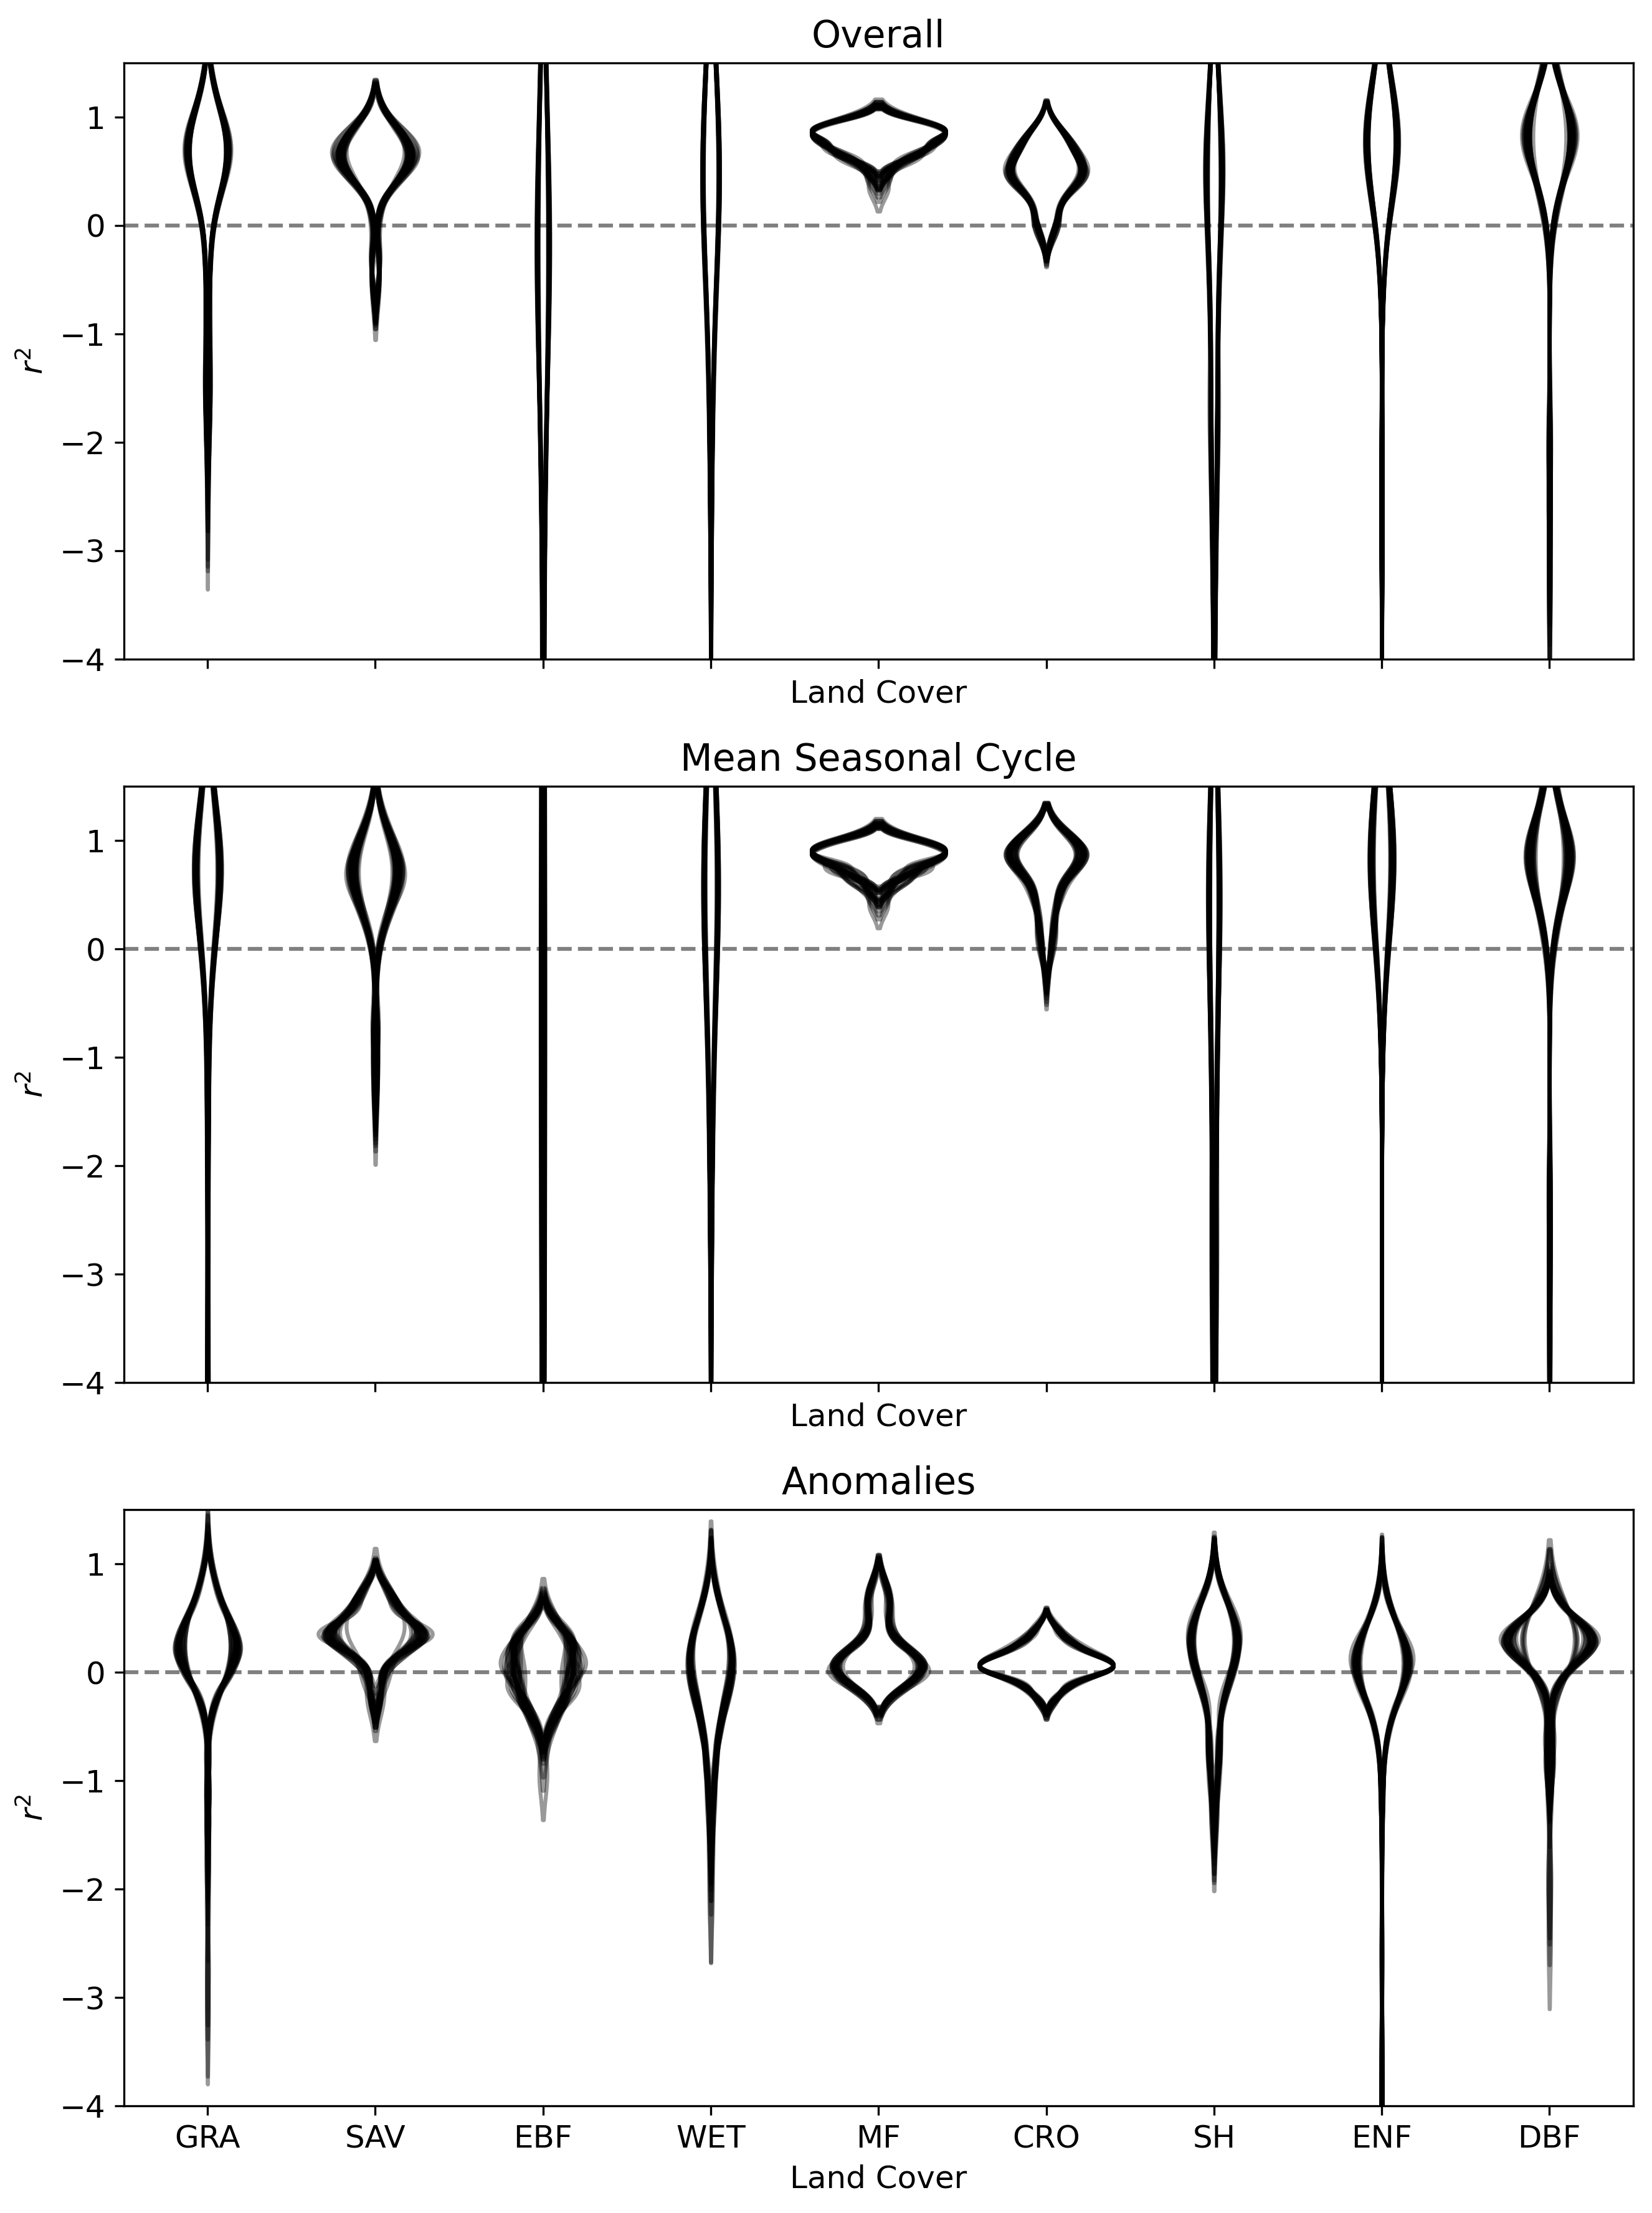

In [36]:
analysis.plt_lc_violin(lc_metrics, 'analysis/benchmark', 'Land Cover', 'exp_id')

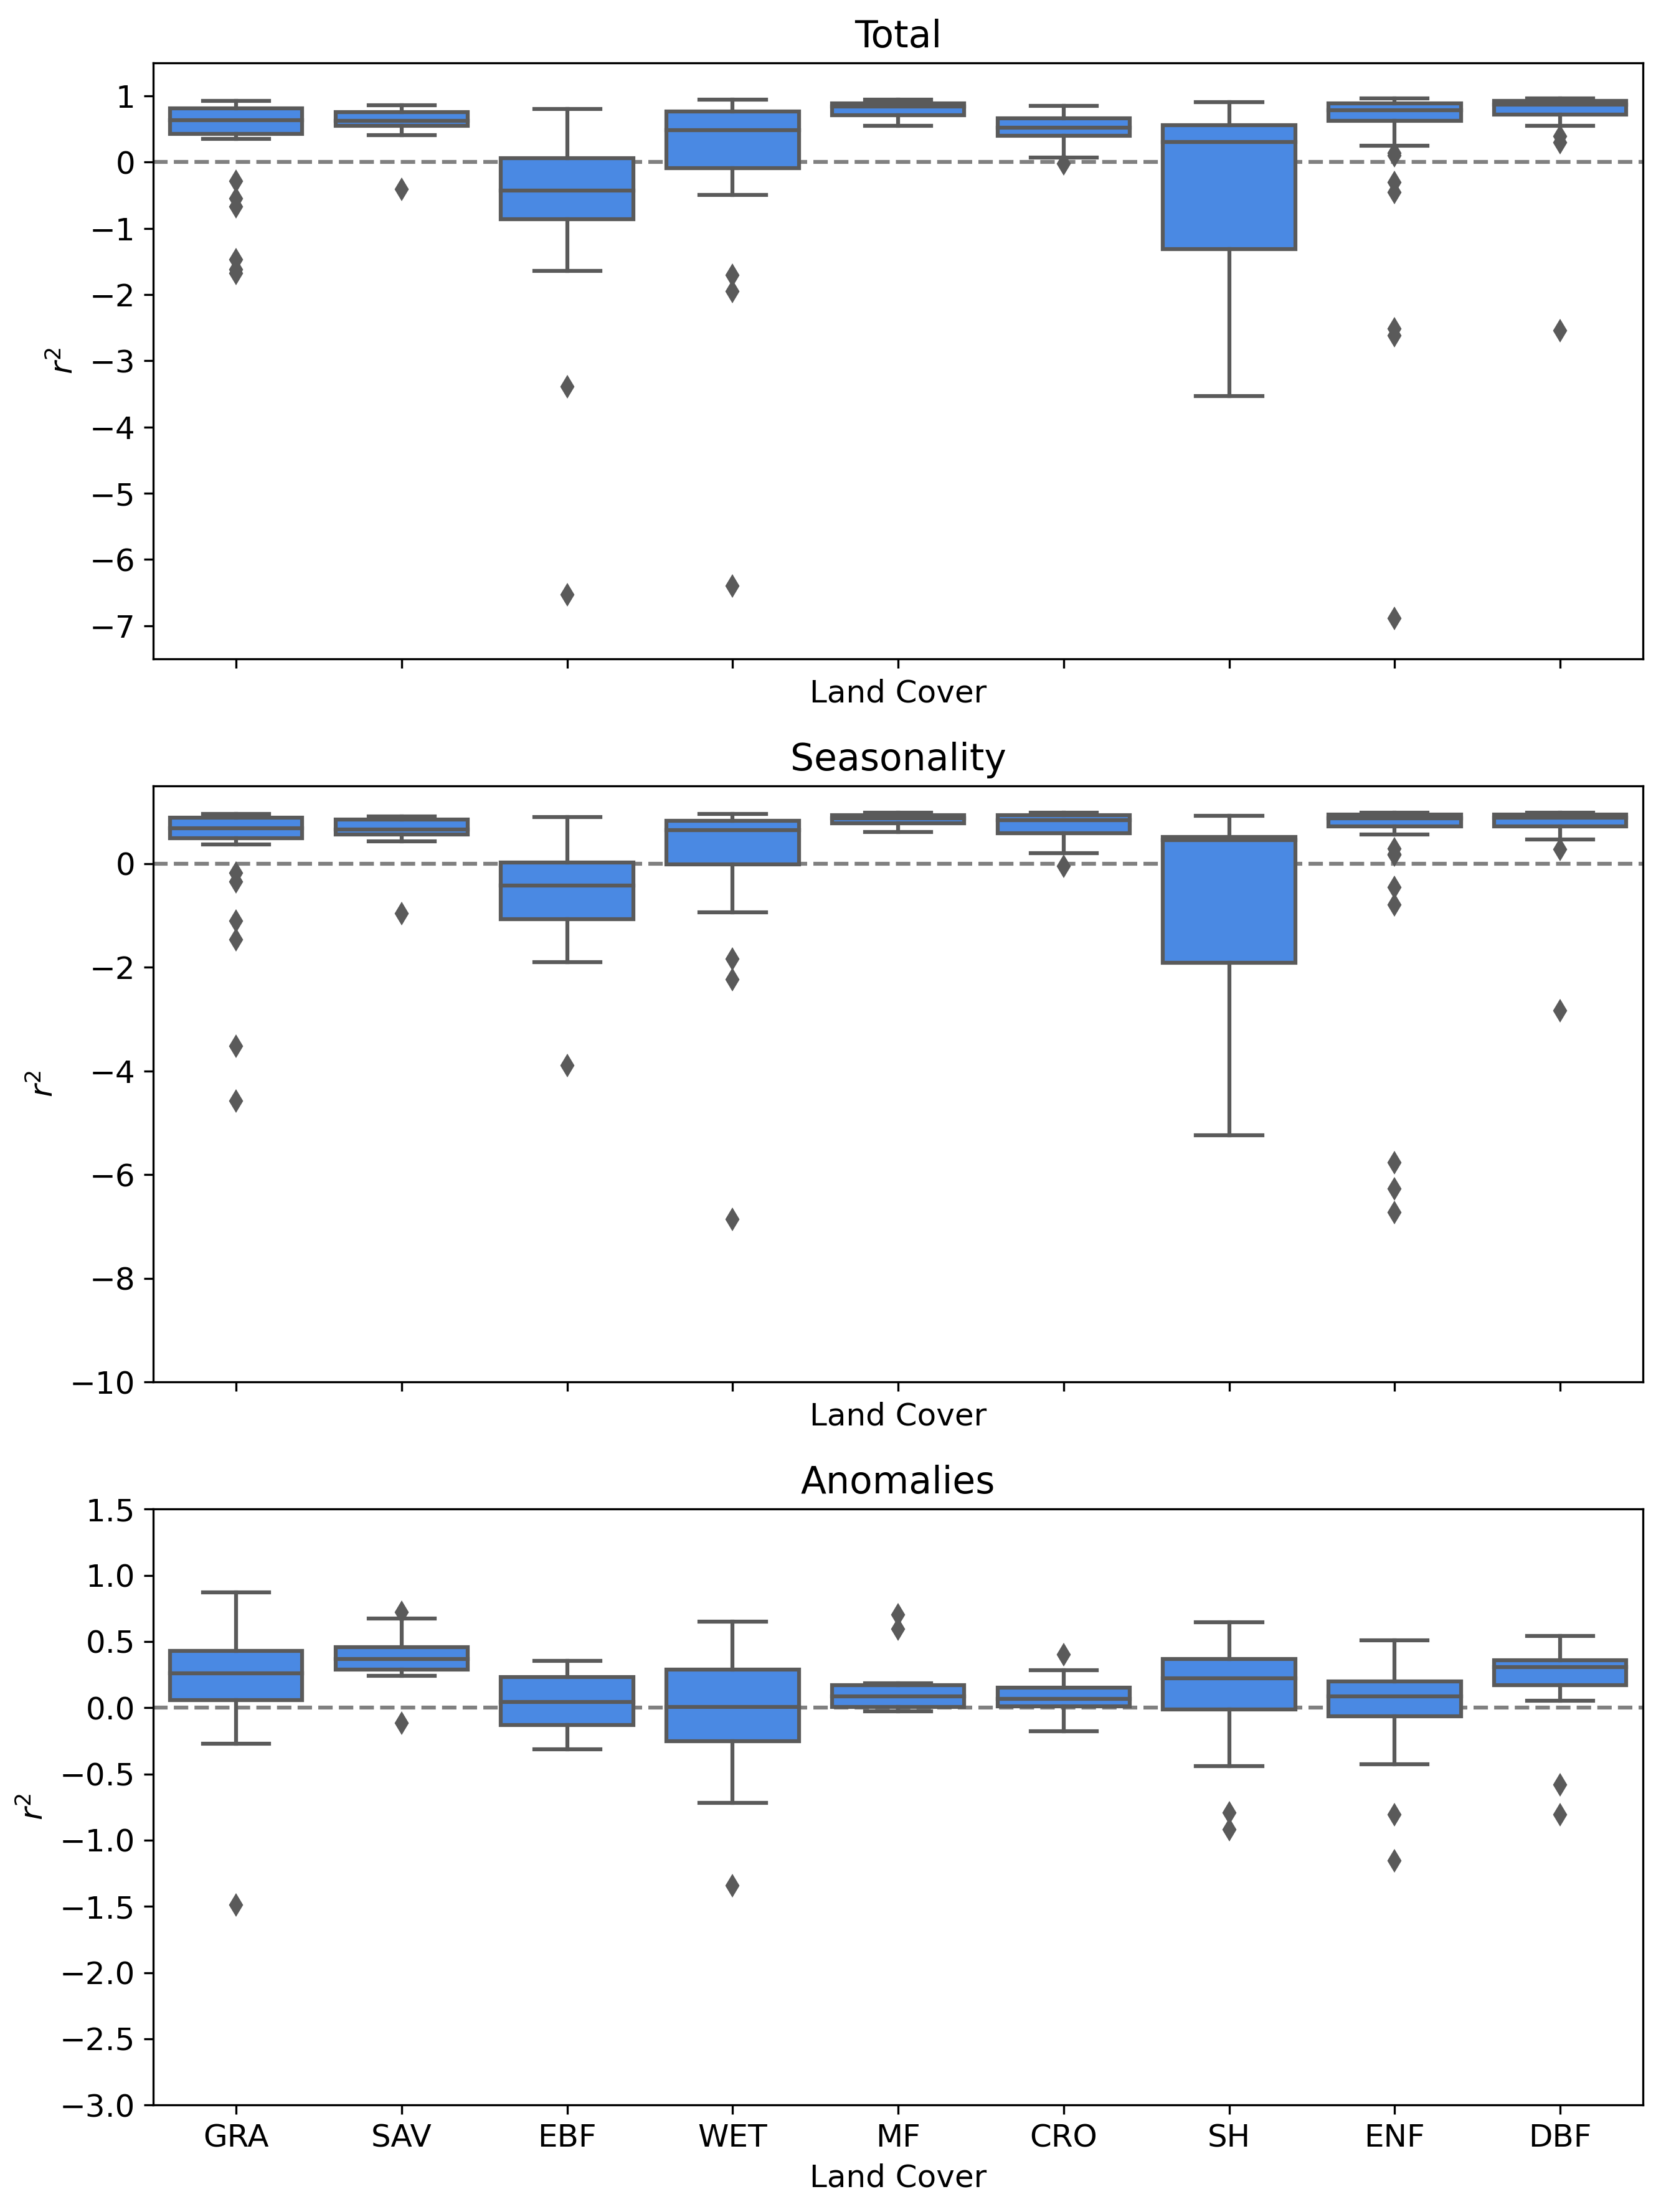

In [19]:
analysis.plt_lc_meanbox(lc_metrics, 'analysis/benchmark', 'Land Cover', 'exp_id')

In [6]:
df500.mean()

exp_id                 inf
r2_overall        0.816387
r2_trend          0.533858
r2_anomalies      0.309122
r2_sites          0.787358
r2_msc            0.872258
rmse_overall      1.641463
rmse_trend        0.016100
rmse_anomalies    1.074594
rmse_sites        0.827838
rmse_msc          1.217555
dtype: float64

In [9]:
df500.std(ddof=1) / np.sqrt(df500.count())

/tmp/ipykernel_279/92989872.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df500.std(ddof=1) / np.sqrt(df500.count())


exp_id                 NaN
r2_anomalies      0.000638
r2_msc            0.000548
r2_overall        0.000520
r2_sites          0.001561
r2_trend          0.002947
rmse_anomalies    0.000512
rmse_msc          0.002603
rmse_overall      0.002320
rmse_sites        0.003028
rmse_trend        0.000051
dtype: float64

### Analyze H2O outlier

In [43]:
outlier = df[df.exp_id == '2022102513552801_1']
# random state: 27
outlier

,exp_id,r2_overall,r2_trend,r2_anomalies,r2_sites,r2_msc,rmse_overall,rmse_trend,rmse_anomalies,rmse_sites,rmse_msc,Explanatory variable set,Framework
7,2022102513552801_1,0.644248,0.443897,0.099519,-0.255736,0.558375,2.287807,0.01711,1.232247,2.010606,2.264414,RS,H2O AutoML


In [2]:
# load original data
data = pd.read_csv('data/ec/data_monthly_0_05_2001-2020_v1.csv', index_col=[0, 1], parse_dates=True)
meta = pd.read_csv('data/ec/sites_meta_v1.csv', index_col=[0])
meta

,start_year,end_year,path,dup,IGBP,LOCATION_ELEV,LOCATION_LAT,LOCATION_LONG,SITE_NAME,koppen_sub,koppen_main,koppen_name,koppen_main_name,Dataset,Climate
SITE_ID,,,,,,,,,,,,,,,
CA-Ca1,1996,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,300.0,49.86730,-125.333600,British Columbia - 1949 Douglas-fir stand,15.0,3,Cfb,Temperate,Ameriflux,temperate
CA-Ca2,1999,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,300.0,49.87050,-125.290900,British Columbia - Clearcut Douglas-fir stand ...,9.0,3,Csb,Temperate,Ameriflux,temperate
CA-Ca3,2001,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,NaN,49.53460,-124.900400,British Columbia - Pole sapling Douglas-fir stand,9.0,3,Csb,Temperate,Ameriflux,temperate
CA-Cbo,1994,2014,/Users/yanghuikang/Documents/Work/Research/Pho...,False,DBF,120.0,44.31670,-79.933300,"Ontario - Mixed Deciduous, Borden Forest Site",26.0,4,Dfb,Cold,Ameriflux,continental
CA-Gro,2003,2014,/Users/yanghuikang/Documents/Work/Research/Pho...,True,MF,340.0,48.21670,-82.155600,"Ontario - Groundhog River, Boreal Mixedwood Fo...",26.0,4,Dfb,Cold,Ameriflux,continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE-Htm,2015,2020,/Users/yanghuikang/Documents/Work/Research/Pho...,True,ENF,NaN,56.09763,13.418970,Hyltemossa,26.0,4,Dfb,Cold,ICOS2020,continental
SE-Lnn,2014,2018,/Users/yanghuikang/Documents/Work/Research/Pho...,False,NaN,71.0,58.34063,13.101770,Lanna,26.0,4,Dfb,Cold,ICOS2018,continental
SE-Nor,2014,2020,/Users/yanghuikang/Documents/Work/Research/Pho...,True,ENF,NaN,60.08650,17.479504,Norunda,26.0,4,Dfb,Cold,ICOS2020,continental


In [3]:
X, y, params, models, train_idx, test_idx, y_pred = utils.Experiment.load('experiments/2022102513552801_1')
X['LC'] = X[[col for col in X if col.startswith('MODIS_LC_')]].idxmax(axis=1)

# get site ids for test partition in each fold
sites = []
for fold in test_idx:
    sites.append(list(X.iloc[fold].index.get_level_values('SITE_ID').unique()))

for fold in sites:
    print(sklearn.metrics.r2_score(y.loc[fold].values, pd.concat(y_pred).loc[fold].values))
    
y_eval = pd.concat([y, pd.concat(y_pred)], axis=1)
y_eval = y_eval.loc[sum(sites, [])]
y_eval = y_eval[(y_eval.GPP_NT_CUT_REF.groupby('SITE_ID').transform(lambda x: x.count()) >= 24)]

sklearn.metrics.r2_score(y_eval['GPP_NT_CUT_REF'].values, y_eval['y_pred'].values)

0.3258131355113294
0.8008113525369723
0.7364361566373727
0.6576748589194856
0.7103941205402405


0.6442480954271068

<AxesSubplot: >

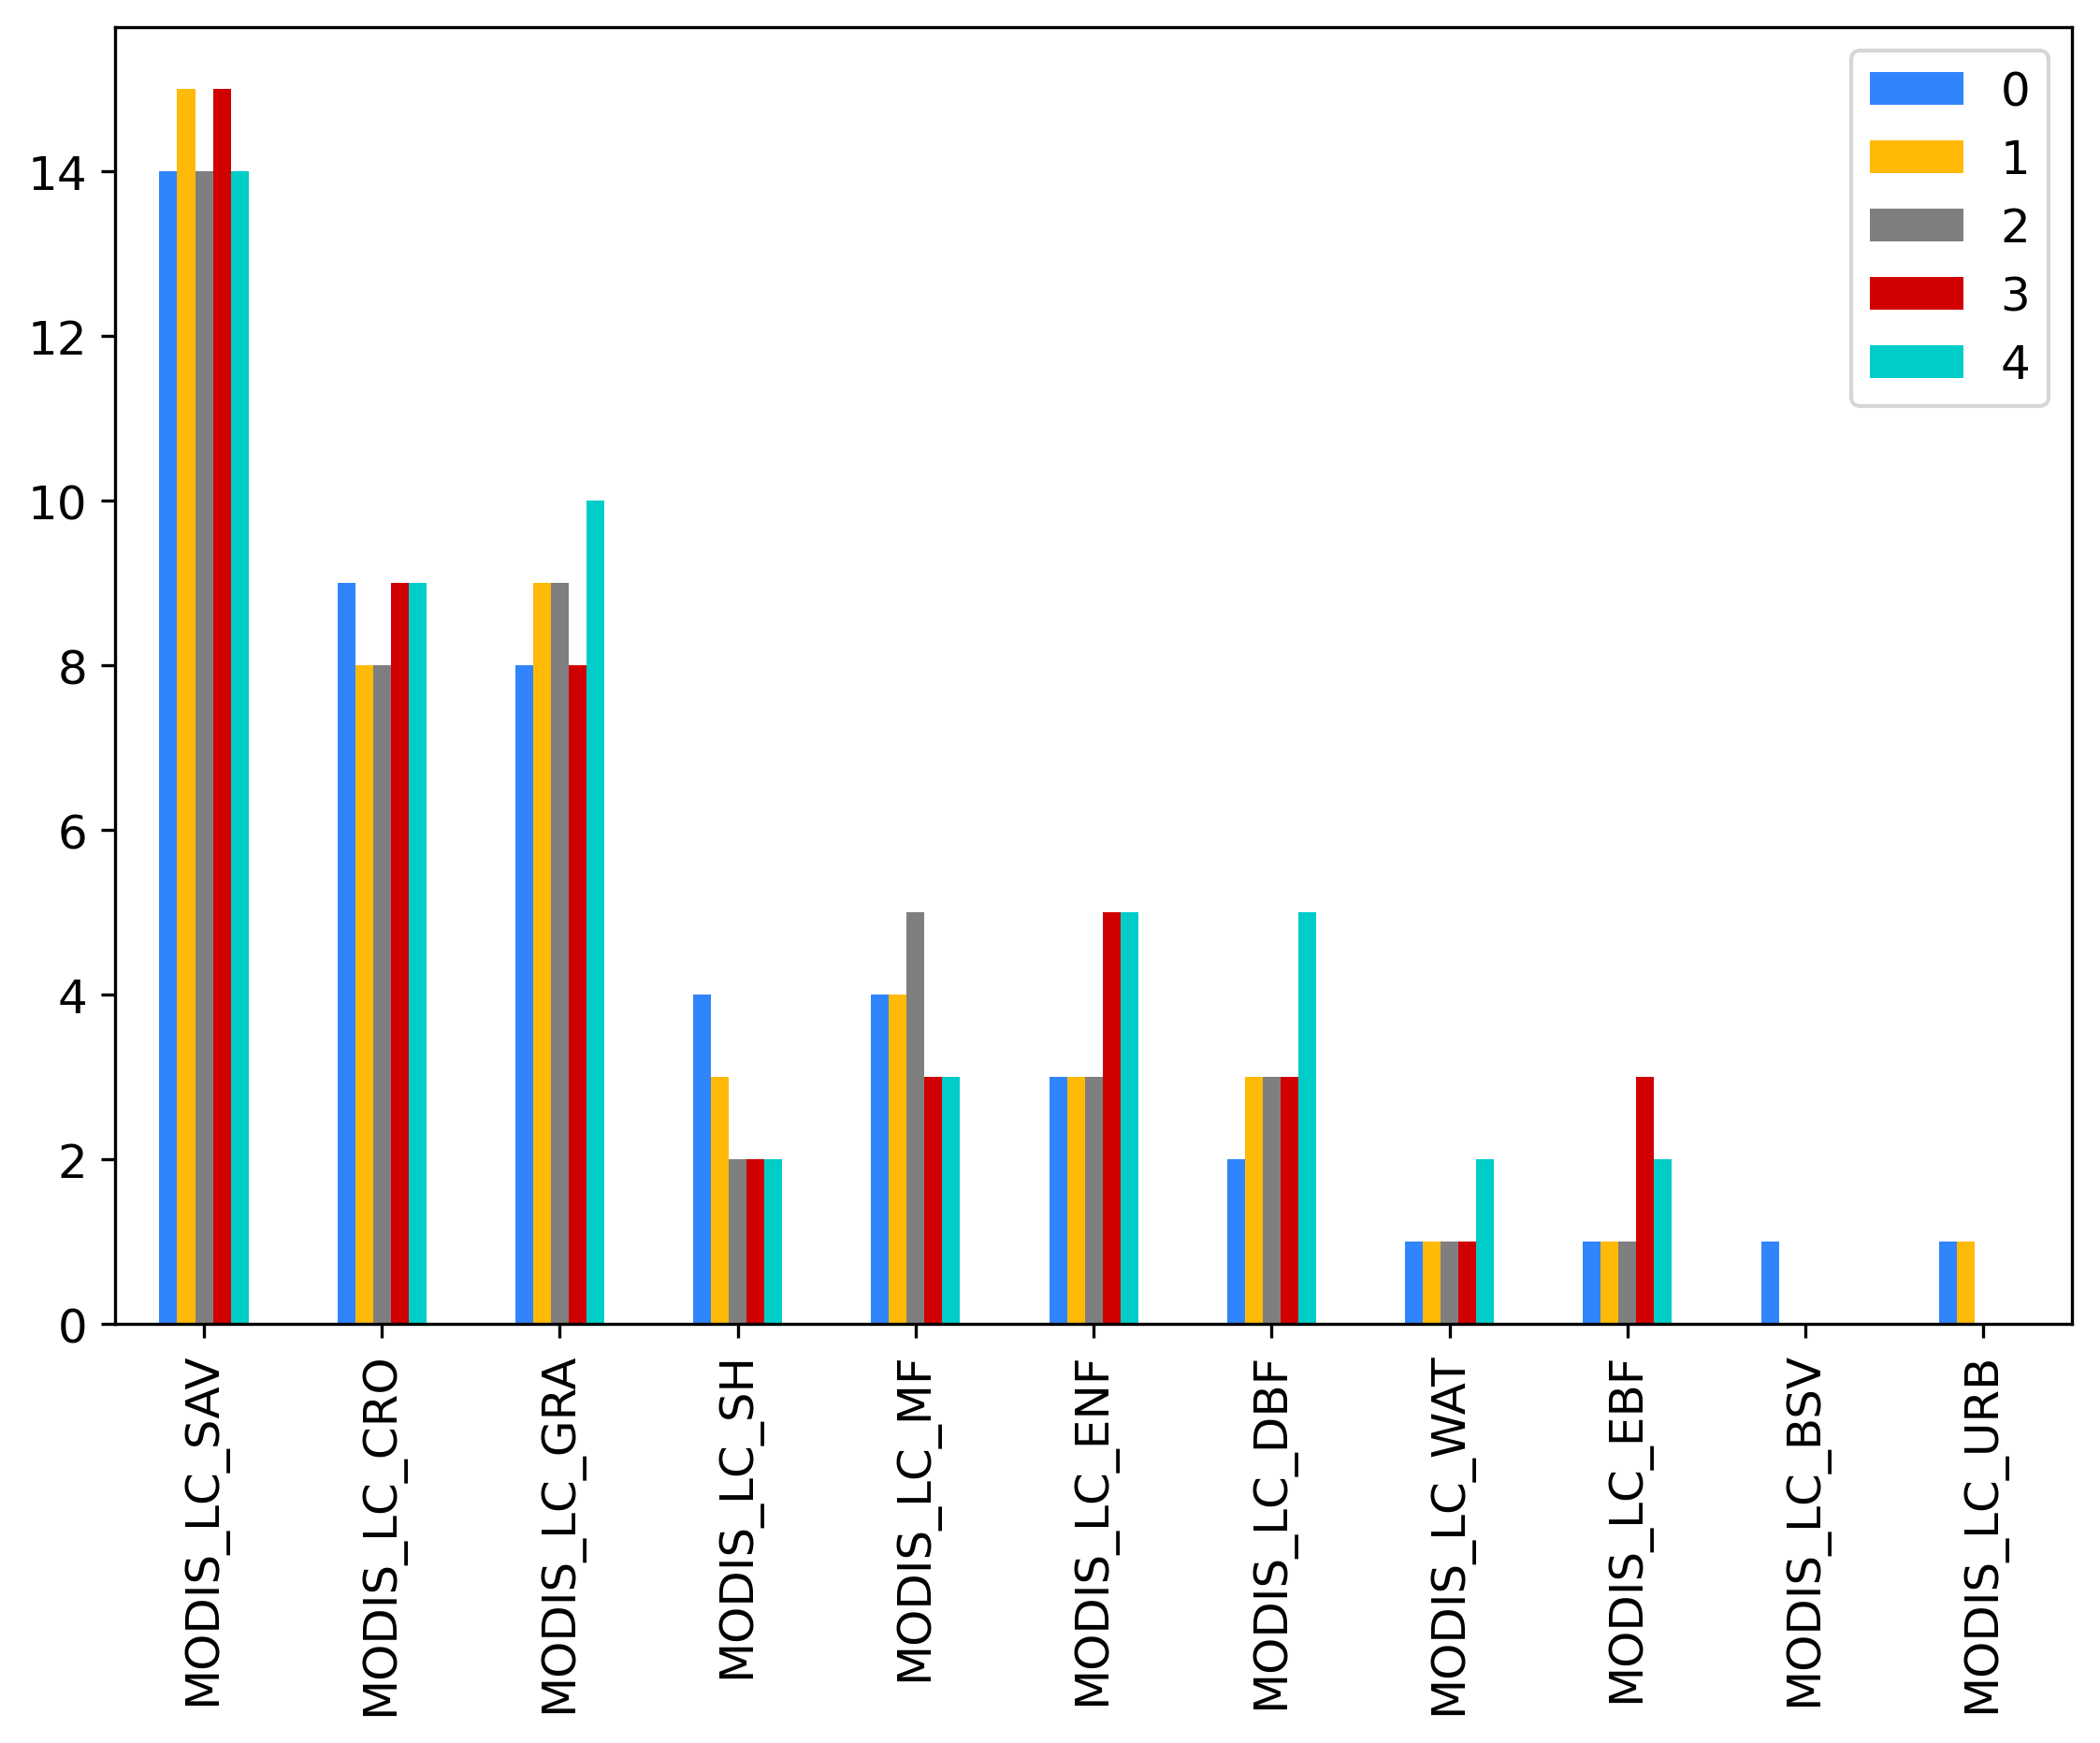

In [4]:
# stat for X (MODIS LC)
out_X_stat = X.copy()
out_X_stat['count'] = out_X_stat.groupby('SITE_ID').transform('count')['b1']
out_X_stat = out_X_stat.groupby('SITE_ID').first()[['count', 'LC']]

fold_counts = []
for fold, sites_sel in enumerate(sites):
    fold_counts.append(out_X_stat.loc[sites_sel, 'LC'].value_counts())
    
fold_counts = pd.concat(fold_counts, axis=1)
fold_counts.columns = range(0, 5)
fold_counts.plot(kind='bar')

<AxesSubplot: >

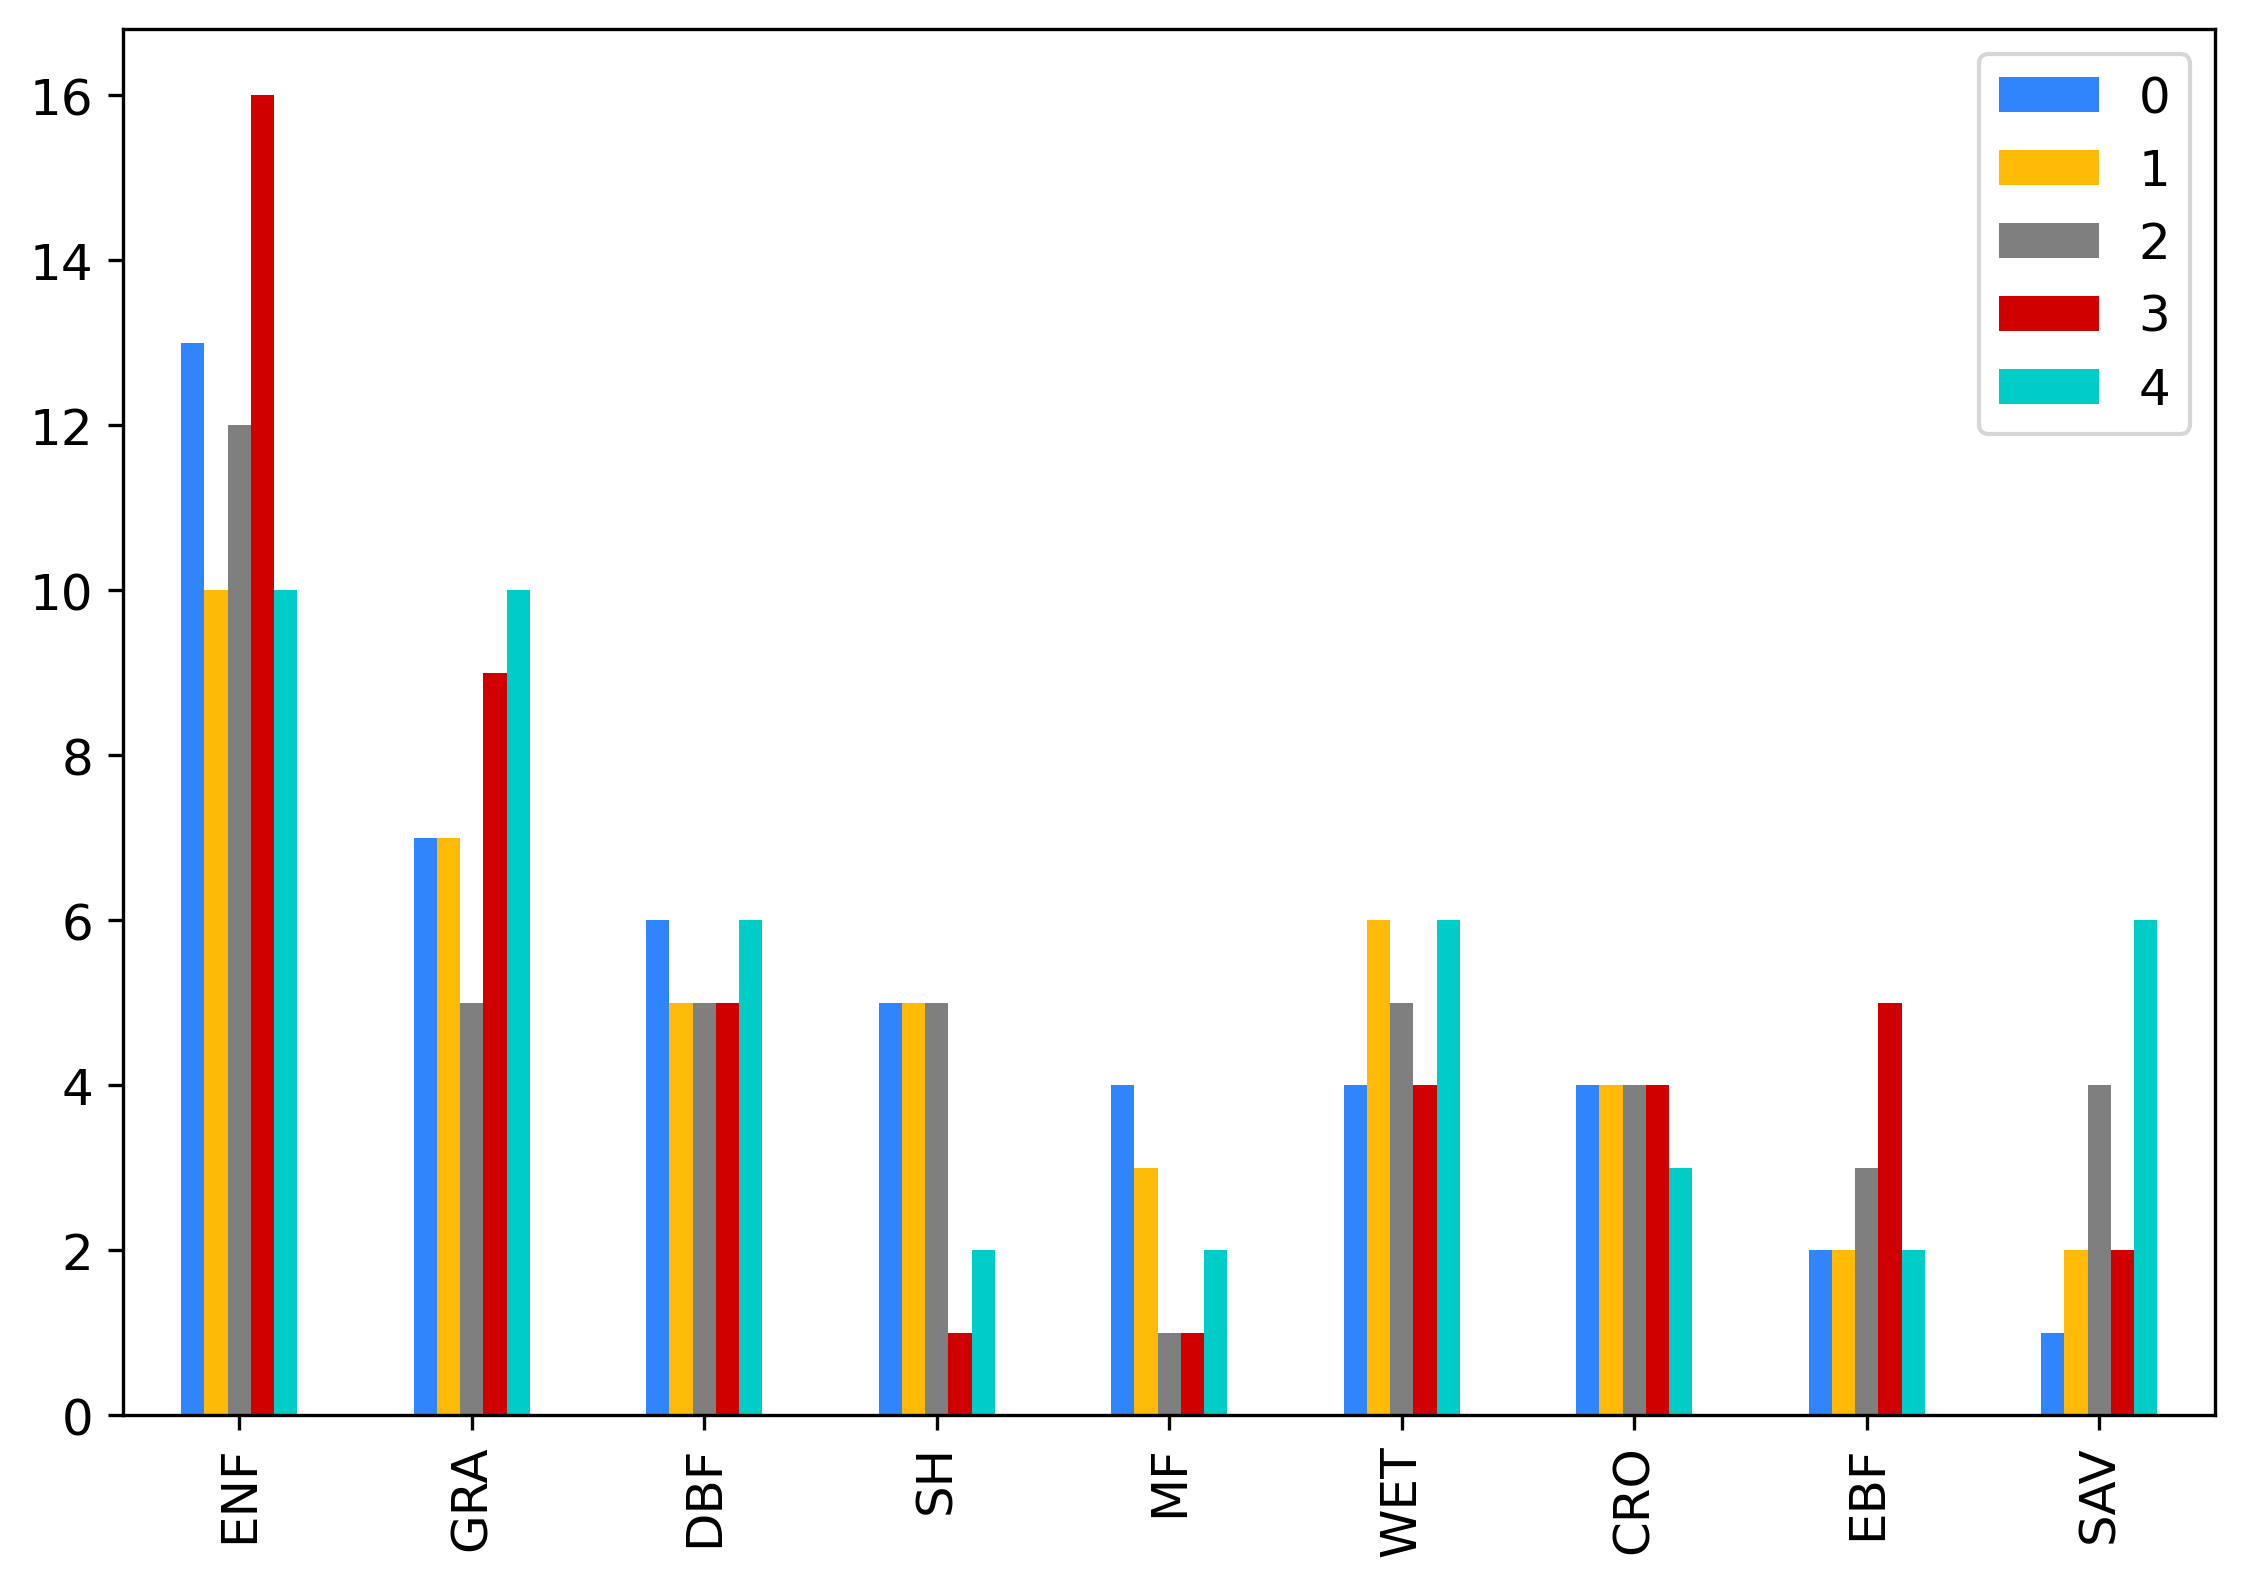

In [5]:
# stat for meta (real LC)
fold_counts = []
for fold, sites_sel in enumerate(sites):
    fold_counts.append(meta.loc[sites_sel, 'IGBP'].value_counts())
    
fold_counts = pd.concat(fold_counts, axis=1)
fold_counts.columns = range(0, 5)
fold_counts.plot(kind='bar')

<AxesSubplot: xlabel='test_fold', ylabel='count'>

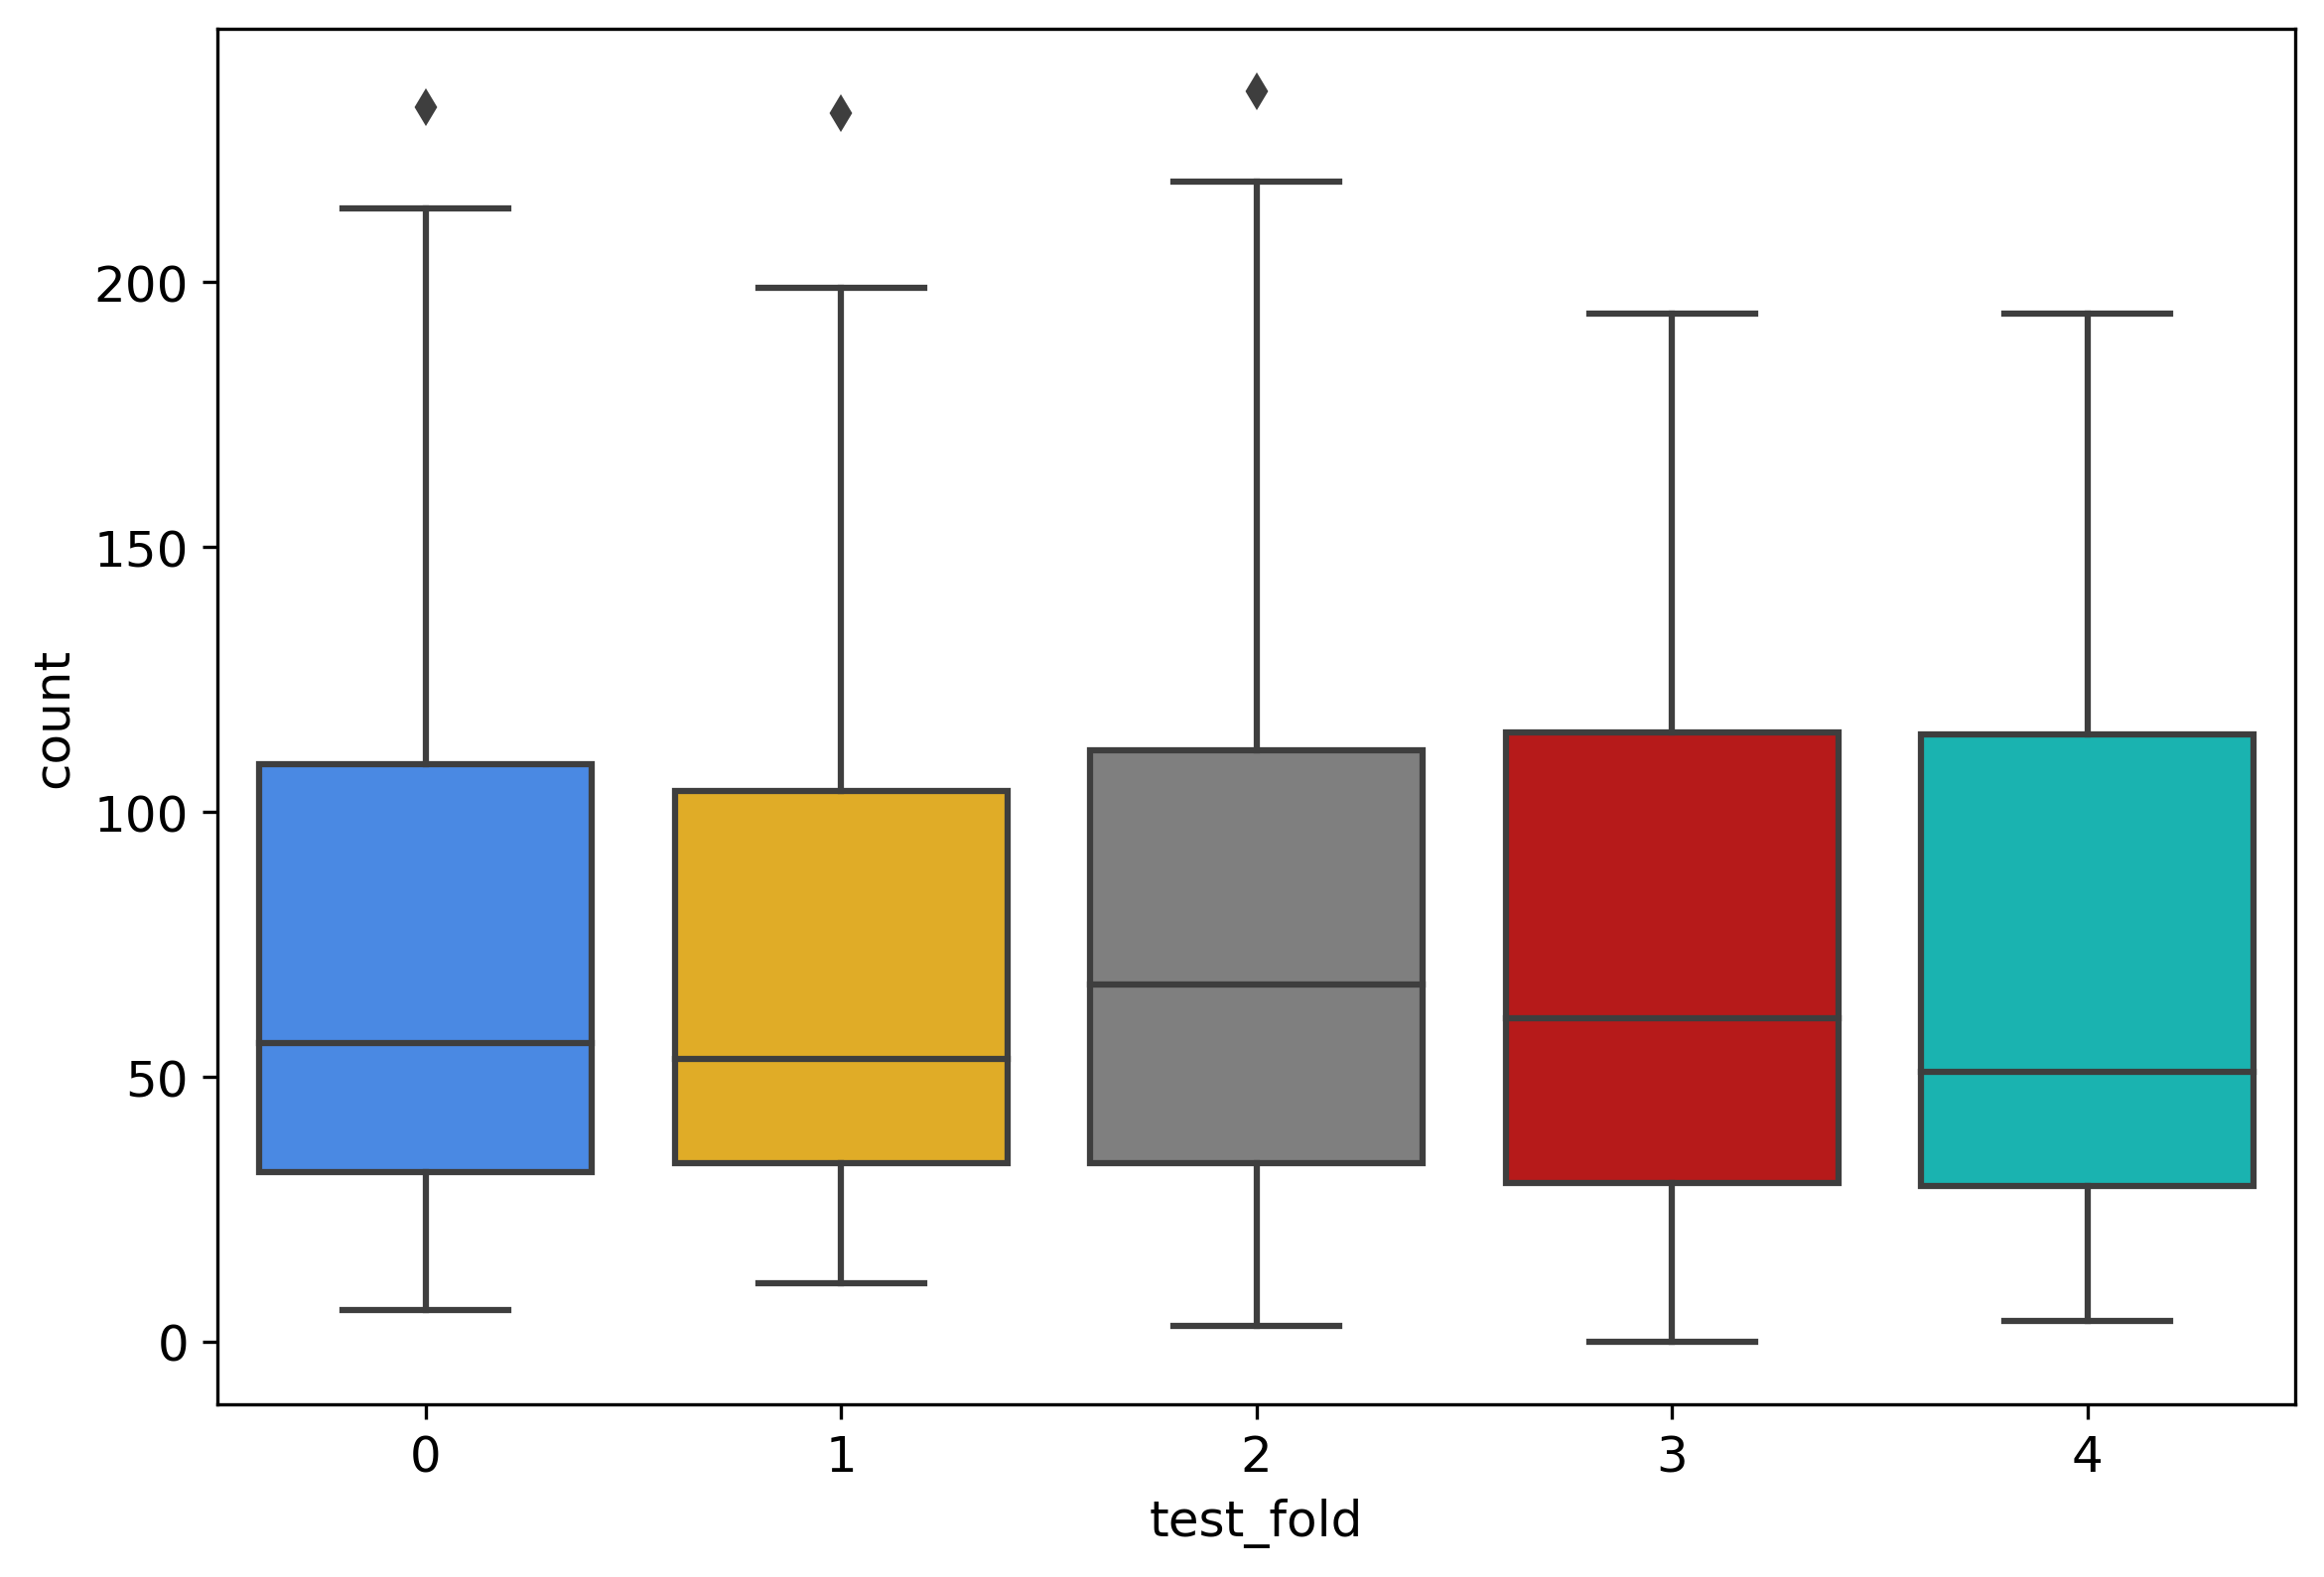

In [6]:
# investigate fold 0
out_X_stat['test_fold'] = 0

for idx, fold in enumerate(sites):
    out_X_stat.loc[fold, 'test_fold'] = idx
    
sns.boxplot(x='test_fold', y='count', data=out_X_stat)

In [7]:
out_X_stat

,count,LC,test_fold
SITE_ID,,,
AR-SLu,15,MODIS_LC_SH,4
AR-Vir,16,MODIS_LC_SAV,2
AT-Neu,121,MODIS_LC_MF,4
AU-ASM,51,MODIS_LC_SH,4
AU-Ade,17,MODIS_LC_GRA,0
...,...,...,...
US-Wi3,12,MODIS_LC_DBF,4
US-Wi4,15,MODIS_LC_MF,1
US-Wjs,114,MODIS_LC_GRA,4


(286, 16)


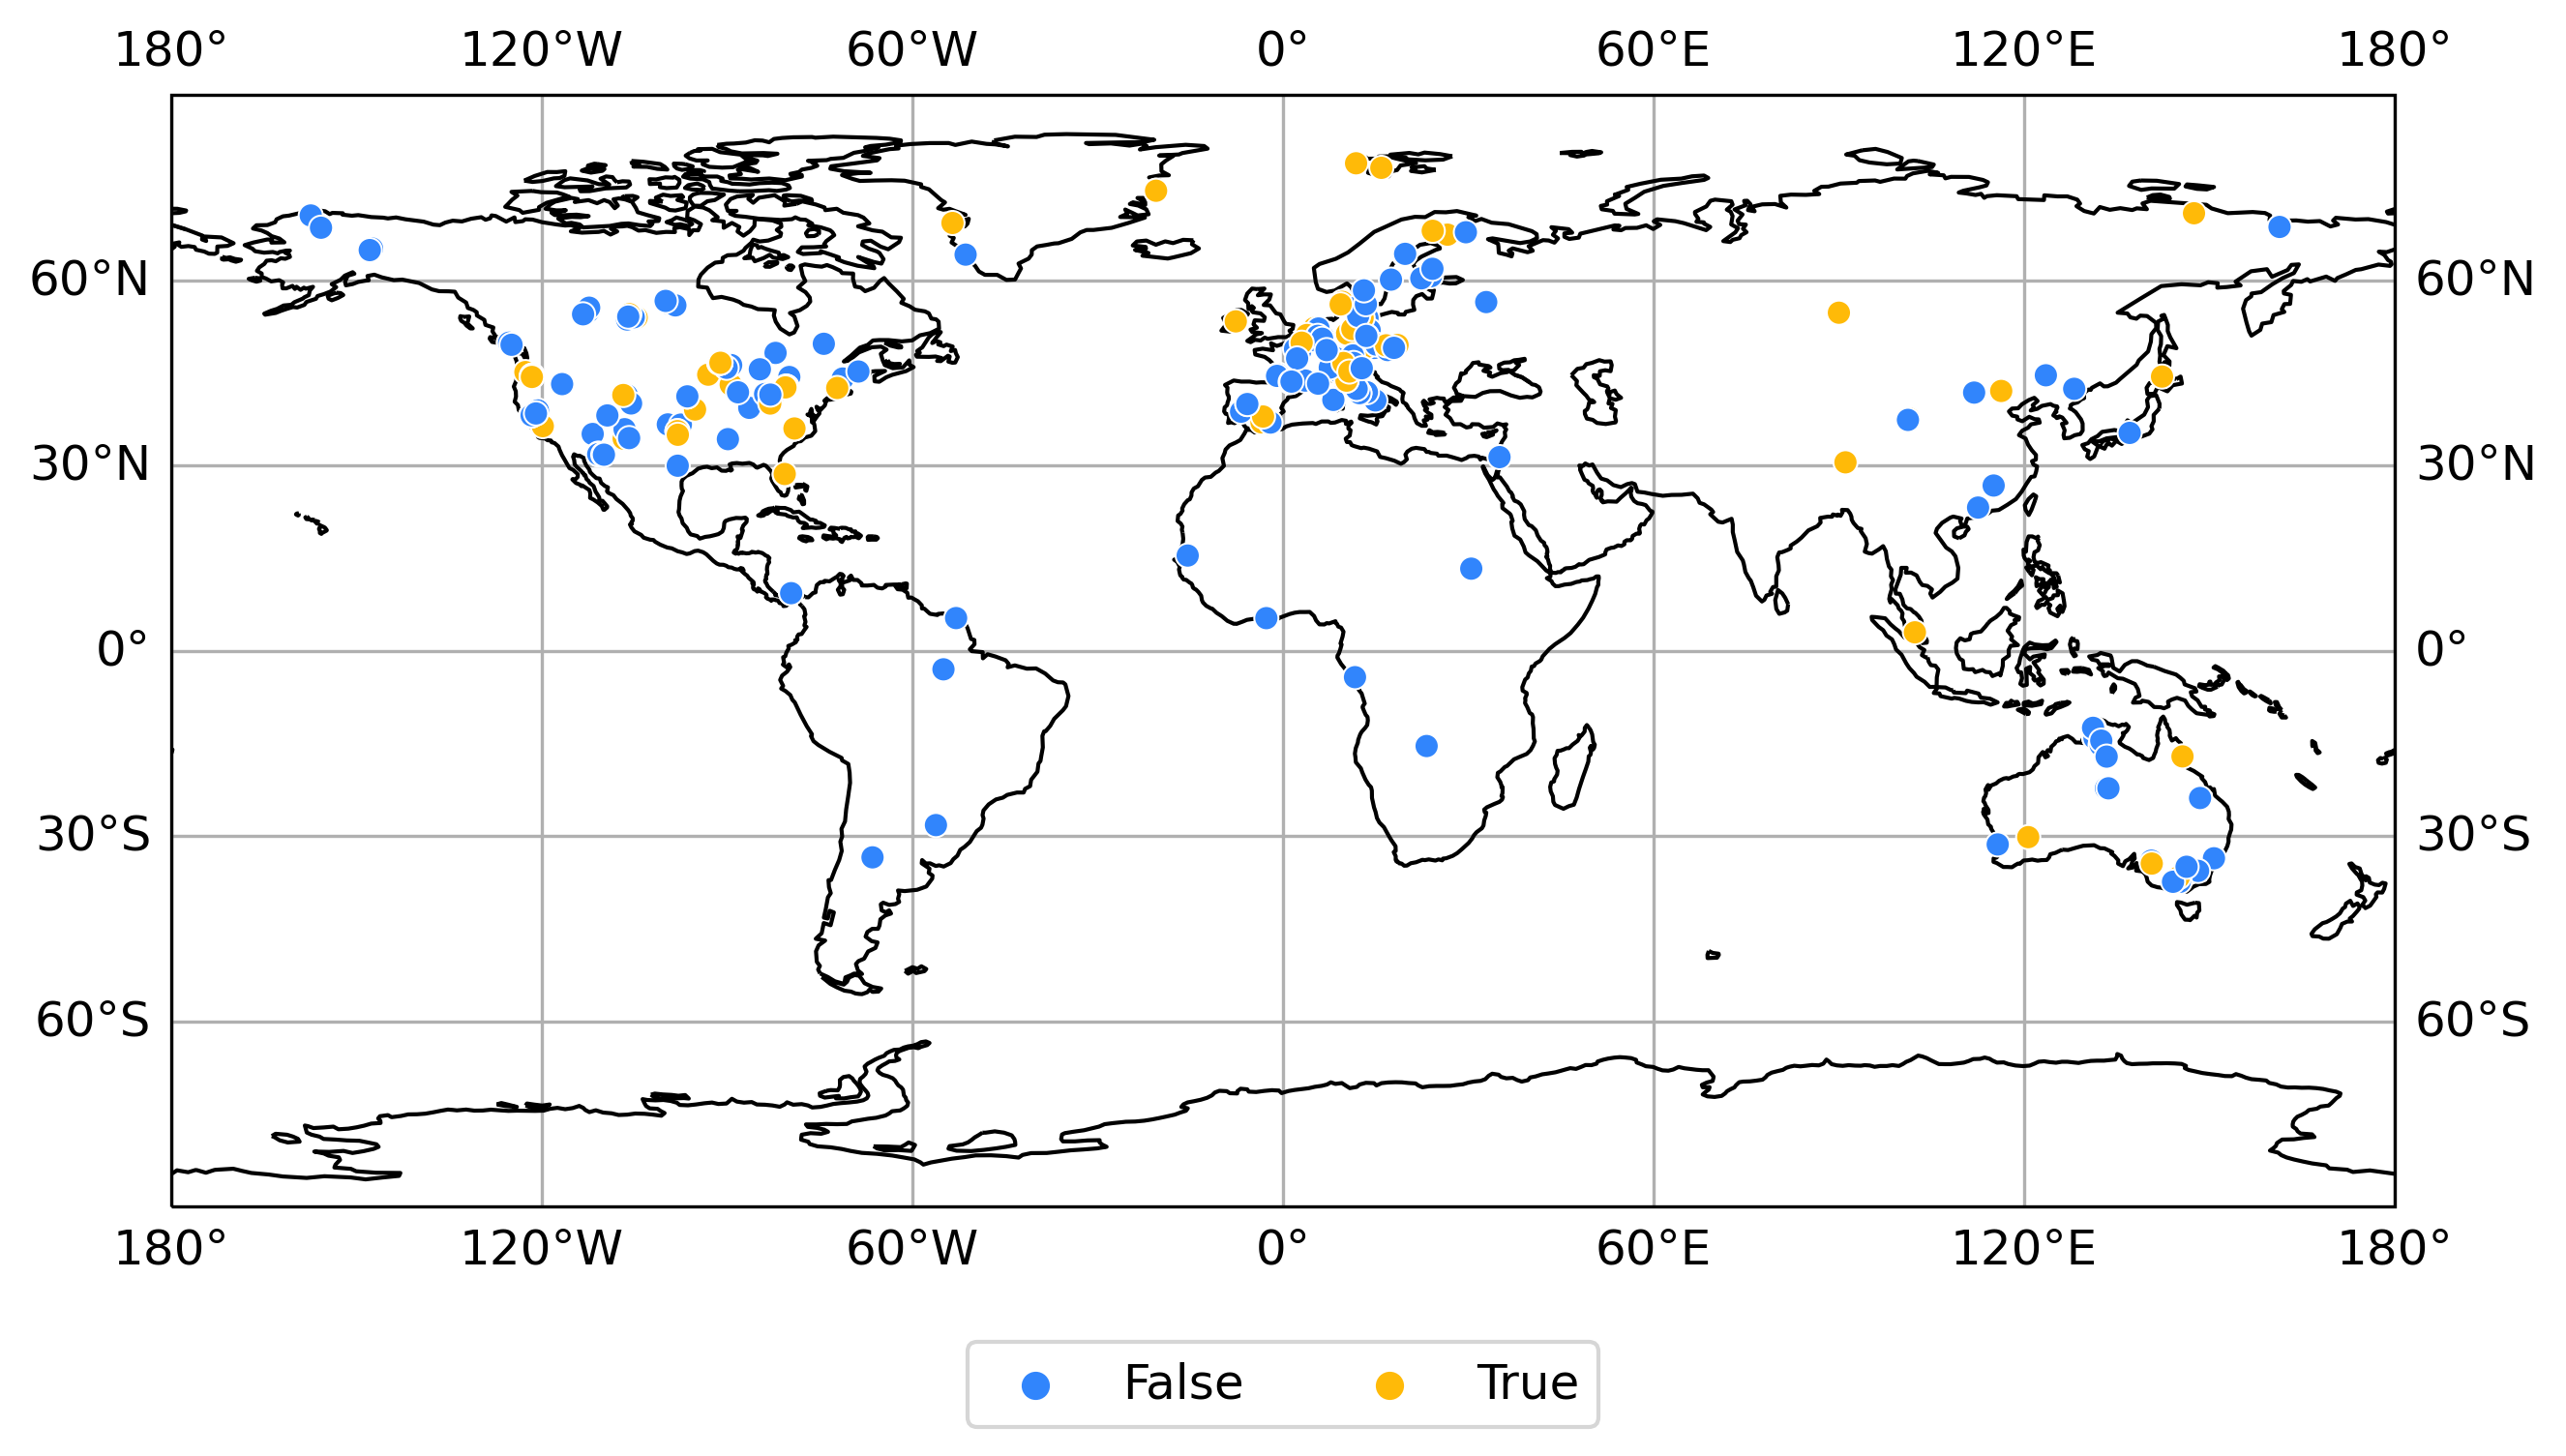

In [112]:
meta_disp = meta.copy()
# investigate fold 0
meta_disp['test_fold'] = 0

for idx, fold in enumerate(sites):
    meta_disp.loc[fold, 'test_fold'] = idx
    
meta_disp['test_fold'] = meta_disp['test_fold'] == 0

print(meta_disp.shape)

fig = plt.figure(figsize=(9, 7))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_global()
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=0)
ax.coastlines(zorder=1)
sns.scatterplot(data=meta_disp, x='LOCATION_LONG', y='LOCATION_LAT', ax=ax, hue='test_fold', sizes=(40, 300), edgecolor='#ffffff')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=5)
plt.tight_layout()
plt.show()

In [13]:
y_stat = pd.DataFrame(y)
y_stat['test_fold'] = 0

for idx, fold in enumerate(sites):
    y_stat.loc[fold, 'test_fold'] = idx

3.300767275731121
3.536564205770568
3.3806011807594776
3.2498073270480976
3.9916363244094644


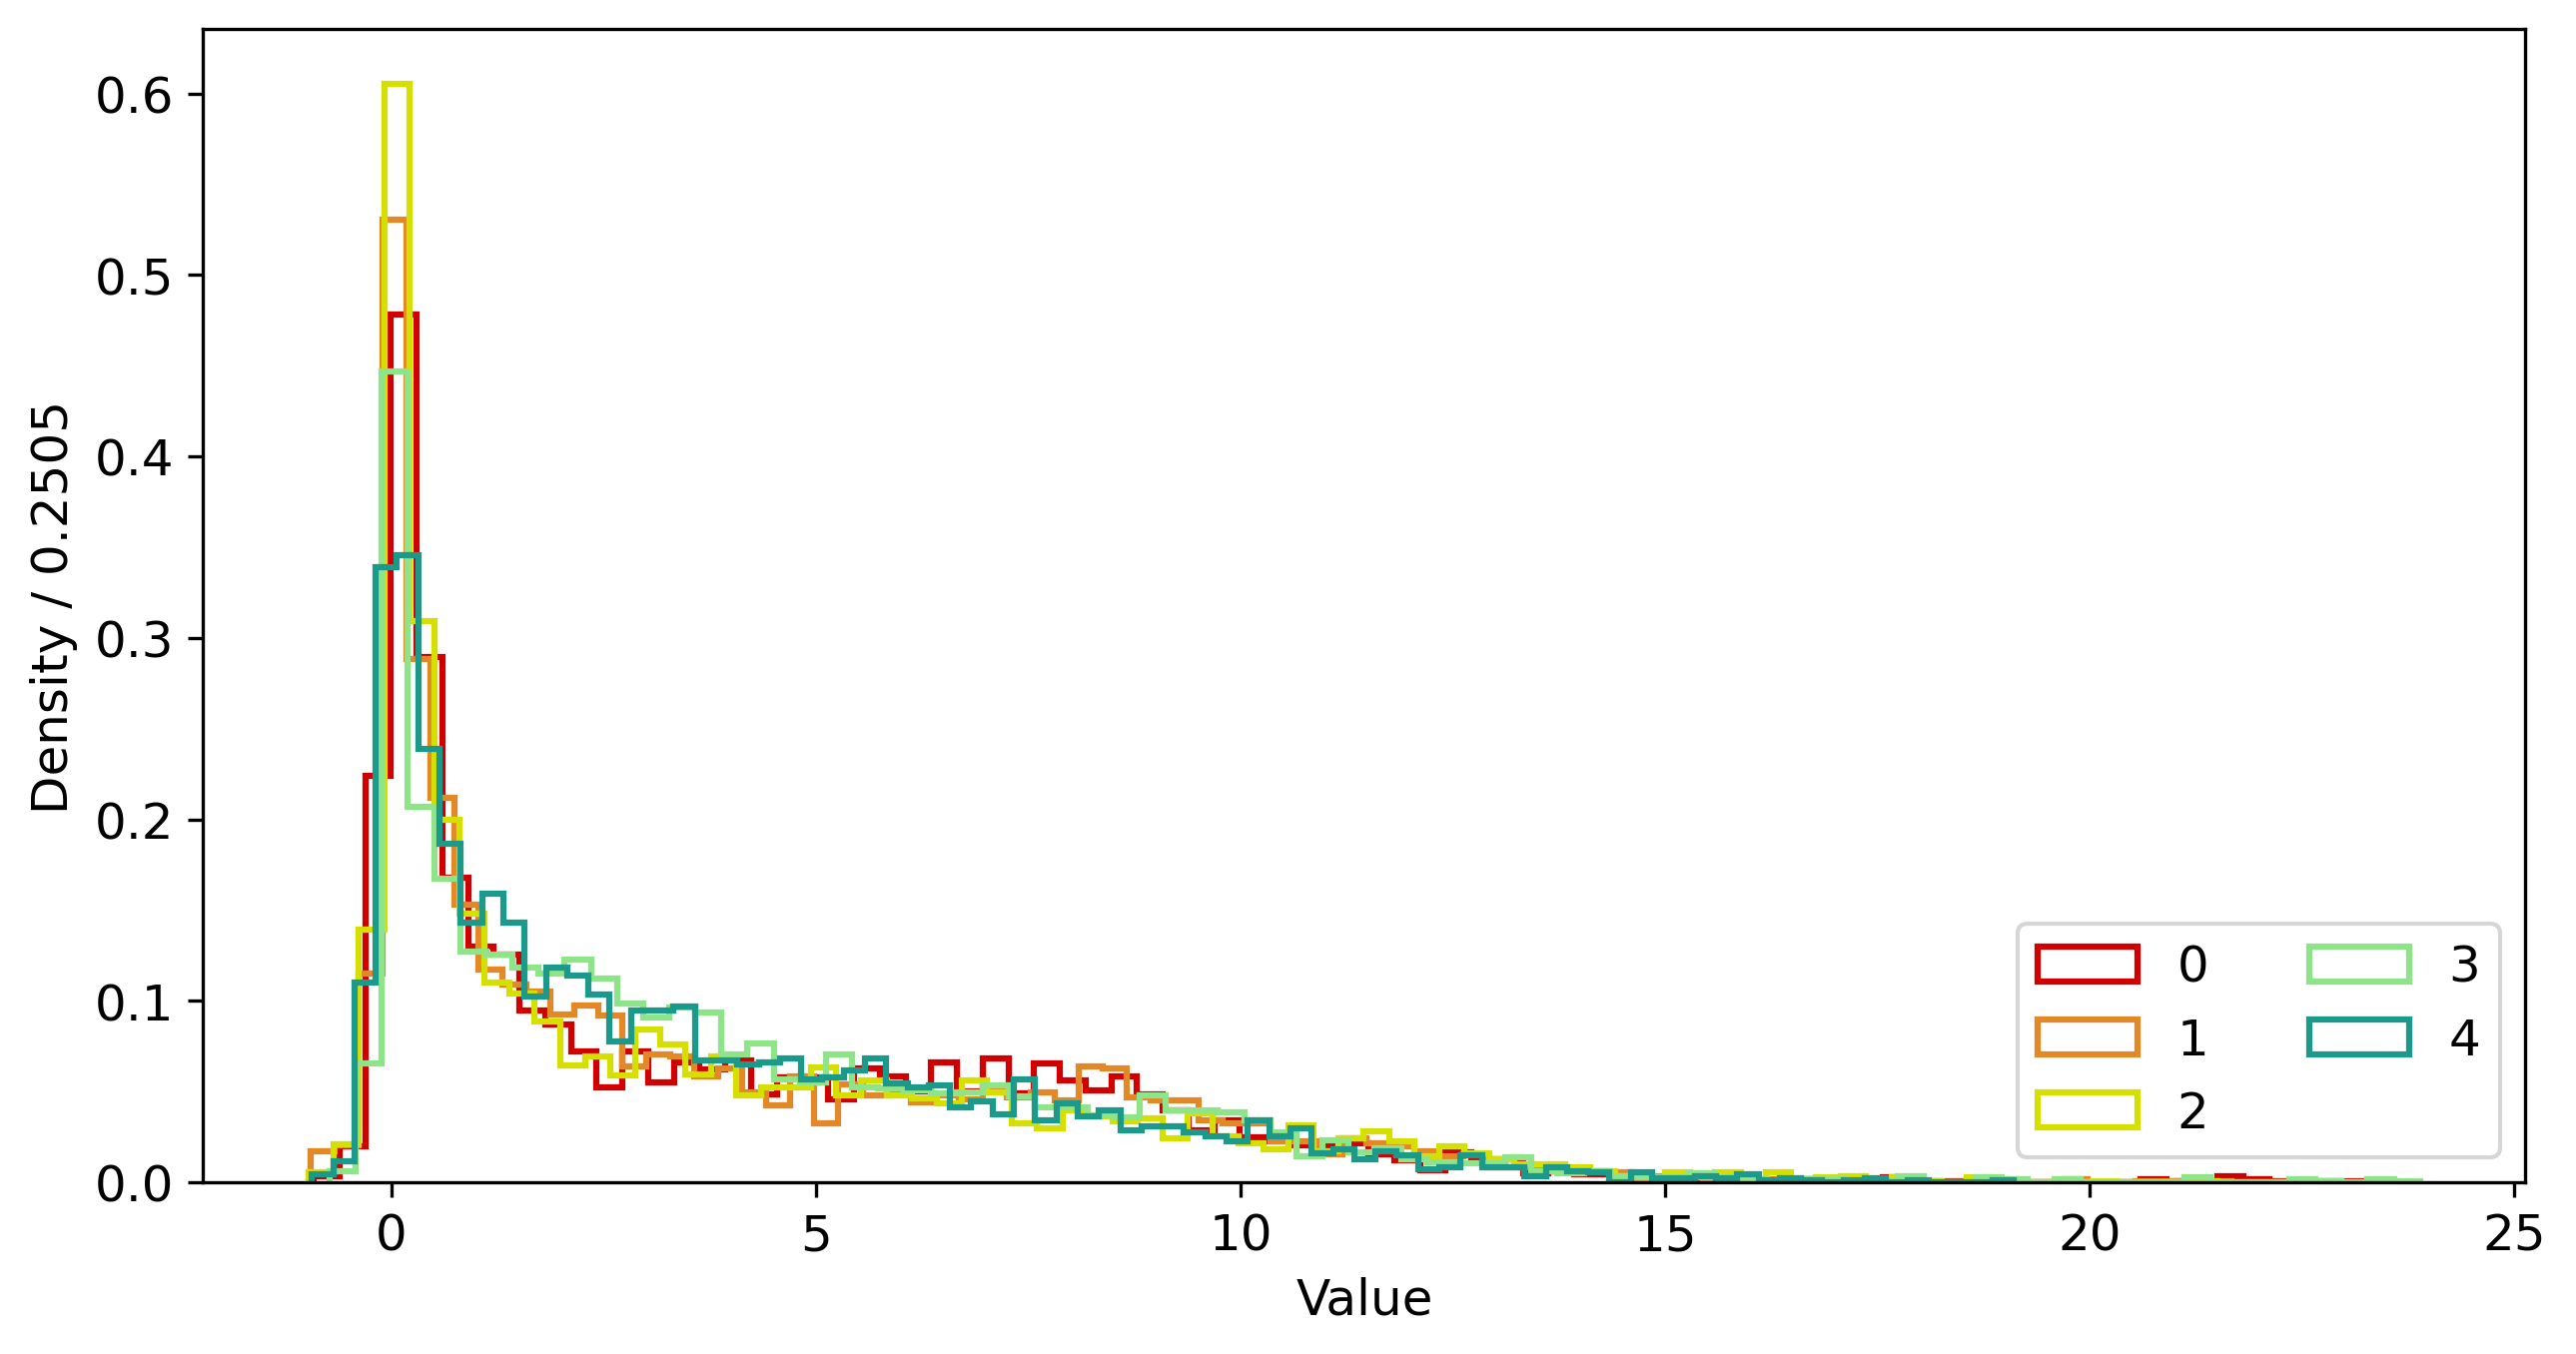

In [21]:
def draw_hist(x_vals, 
              n_bins, 
              rng=None, 
              x_fit=None, 
              fit_func=None,
              fit_params={},
              fit_scale=False,
              errs=False, 
              density=False,
              fit_info=None,
              ax=None, 
              fit_color='red', 
              hist_color='black',
              hist_alpha=1,
              fit_label='Fitted curve',
              hist_label='Histogram',
              x_label='Value',
              legend=True, 
              **kwargs):
    '''Draws a histogram

    Args:
        x_vals (array): Values to be binned
        n_bins (int): Number of bins
        rng (tuple): Minimum and maximum x value
        x_fit (array): Array of fitted x values
        fit_func (array): Fitting function
        fit_params (dict): Fitting parameters
        errs (bool): Errorbars on histogram
        fit_info (list): List of fit info for chart legend
        ax (matplotlib.axis): Axis object

    Returns:
        matplotlib axis object

    TODO:
        scaling factor N?
    '''
    plot = False
    if ax is None:
        plot = True
        fig, ax = plt.subplots(figsize=(10, 5))

    # histogram
    n_hist, x_loc, _ = ax.hist(x_vals, bins=n_bins, range=rng, density=density, label=hist_label, color=hist_color, histtype='step', alpha=hist_alpha, linewidth=1.5)

    print(np.sum(n_hist))

    # normalize with N_points * binwidth
    # binwidth = (xmax - xmin) / n_bins
    binwidth = np.abs(np.max(x_loc) - np.min(x_loc[0]))/n_bins
    #binwidth = np.abs(x_loc[1] - x_loc[0])
    n_points = len(x_vals)
    N = n_points * binwidth
    x_loc = (x_loc + binwidth/2)[:-1]

    # plot scatter and error bars
    if errs:
        ax.errorbar(x_loc, n_hist, yerr=np.sqrt(n_hist * (binwidth**(density))), ls='None', capsize=3, color=hist_color)

    # curve
    if fit_func is not None:
        if x_fit is None:
            x_fit = np.linspace(x_loc[0], x_loc[-1], 1000)

        ax.plot(x_fit, (fit_scale * N + 1 - fit_scale) * fit_func(x_fit, **fit_params), label=fit_label, color=fit_color)
    if density:
        ylabel = 'Density'
    else:
        ylabel = 'Frequency'

    ax.set(xlabel=x_label, ylabel=ylabel + " / " + str(np.around(binwidth, 4)), **kwargs)

    if legend:
        leg_title = ''
        if fit_info is not None:
            leg_title = "\n".join(fit_info)
        ax.legend(title=leg_title, loc=4, ncol=2)

    if plot == False:
        return ax
    else:
        plt.show()
        
fig, ax = plt.subplots(figsize=(10, 5))
bins = 80
rng = None

for fold, col in enumerate(['#D00000', '#E28826', '#D5E002', '#8FE388', '#1B998B']):
    draw_hist(y_stat.loc[y_stat.test_fold == fold, 'GPP_NT_CUT_REF'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label=fold, hist_color=col)
    
plt.show()

<AxesSubplot: xlabel='test_fold', ylabel='GPP_NT_CUT_REF'>

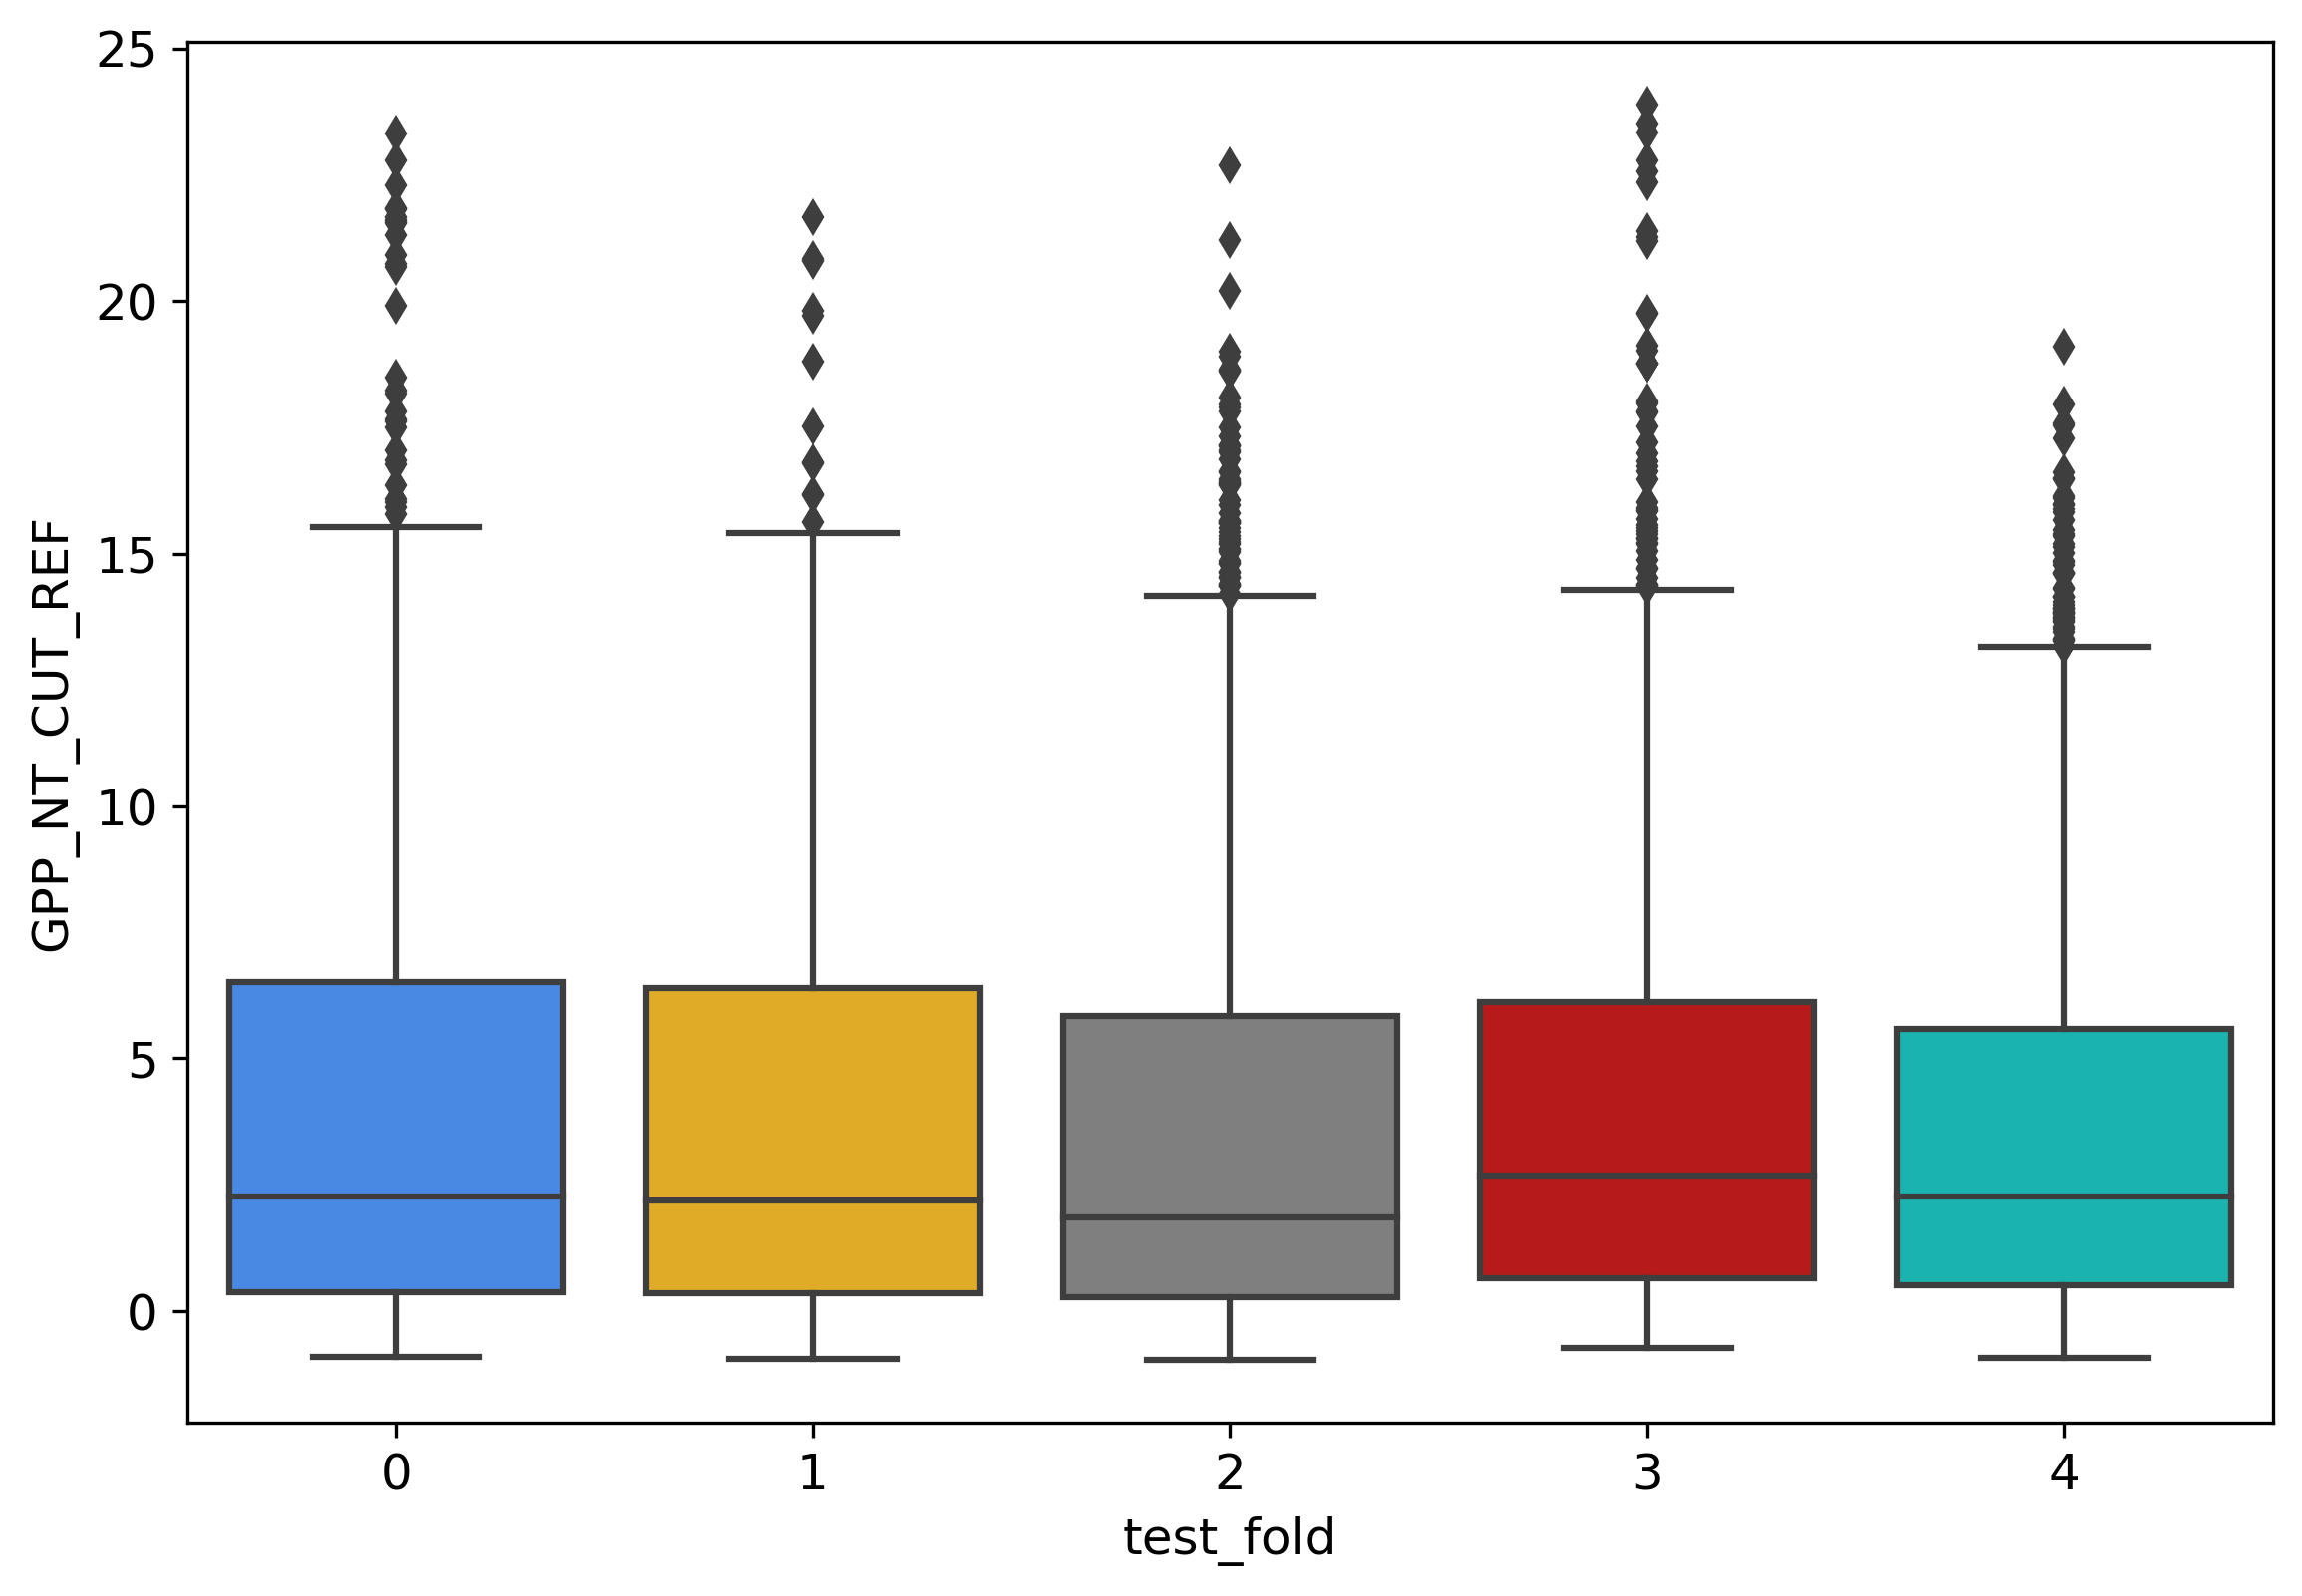

In [22]:
sns.boxplot(x='test_fold', y='GPP_NT_CUT_REF', data=y_stat)